In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import pickle
from pprint import pprint
from collections import Counter
from transformers import AutoTokenizer

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(
    'meta-llama/Meta-Llama-3-8B-Instruct',
    model_max_length=512,
    padding_side='left',
    trust_remote_code=True,
    use_fast=False,
)

/home/chalbeise/miniconda3/envs/mcts-dpo/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
def get_name(node):
    name = '<s>' if not node.depth else tokenizer.decode(node.action)
    name = name.replace('\\', '/')
    text = '[{}] {}'.format(node.N, name)
    tokens = text.split()
    num_per_line = (int(len(tokens) ** .5) + 1)# * 2
    line_cnt = (len(tokens) + num_per_line - 1) // num_per_line
    name = '\n'.join(' '.join(tokens[i*num_per_line: (i+1)*num_per_line]) for i in range(line_cnt))
    try:
        p = node.p
    except:
        p = 1
    # return name + '\n(Q: {:.5f}) (P: {:.5f}) (R: {:.5f})'.format(node.Q, p, np.exp(node.reward))
    return name + '\n(Q: {:.5f}) (P: {:.5f}) \n (V: {:.5f}) \n terminal:{} \n reward:{:.5f}'.format(node.Q if node.Q is not None else -1, p, node.V, node.is_terminal, node.value)

def add_edges_with_path(graph, node, parent_name, path, cur_node):
    child_name = get_name(node)
    if node.id in path:
        graph.add_edge(parent_name, child_name, color = "red")
        if node.id == cur_node.id:
            graph.nodes[child_name]['color'] = 'green'
        else:
            graph.nodes[child_name]['color'] = 'red'
    else:
        graph.add_edge(parent_name, child_name, color = "blue")
    v = node.children
    if v is not None:
        for vv in v:
            add_edges_with_path(graph, vv, child_name, path, cur_node)

def draw_tree_with_path(tree, cur_node, path, fig=None, ax=None):
    graph = nx.DiGraph()
    k = get_name(tree)
    if tree.id in path:
        if tree.id == cur_node.id:
            graph.add_node(k, color = "green")
        else:
            graph.add_node(k, color = "red")
    else:
        graph.add_node(k, color = "blue")
    v = tree.children
    if v is not None:
        for vv in v:
            add_edges_with_path(graph, vv, k, path, cur_node)    
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use the pygraphviz layout for horizontal tree structure
    pos = nx.nx_agraph.graphviz_layout(graph, prog='dot', args='-Grankdir=LR')

    node_colors = [graph.nodes[n].get('color', 'blue') for n in graph.nodes]
    edge_colors = [graph[u][v].get('color', 'blue') for u, v in graph.edges]
    nx.draw(graph, pos, with_labels=True, arrows=False, ax=ax, font_size=16, node_color=node_colors, edge_color=edge_colors)
    ax.set_title("Tree Visualization")
    fig.set_facecolor("w")
    fig.subplots_adjust(left=0.05, right=1.00, top=1.01, bottom=.01)
    # fig.savefig(save_pth, format='pdf')
    plt.show()

In [3]:
def print_prompt_and_answer(output_path, file_name='mcts_rst_prompt_answer.pkl'):
    with open(f'{output_path}/{file_name}', 'rb') as f:
        dump_data = pickle.load(f)

    prompt = tokenizer.decode(dump_data['input_ids'])
    answer = dump_data['answer']
    reasoning = dump_data['reasoning']

    print(f"\nPrompt: {prompt}")
    print(f"\nAnswer: {answer}")
    print(f"\nReasoning: {reasoning}")

In [4]:
output_dir = '/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs_llama3'
epoch = 0
batch_cnt = 0
batch_dir = f'{output_dir}/epoch_{epoch}/batch_cnt_{batch_cnt}'
print_prompt_and_answer(batch_dir)


Prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?<|eot_id|><|start_header_id|>assistant<|end_header_id|>



Answer: 72

Reasoning: Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72
The answer is 72


In [5]:
def visualize_iteration_trees(batch_dir, node_cnt, search_cnt, file='mcts_history.pkl'):
    with open(f'{batch_dir}/{file}', 'rb') as f:
        history = pickle.load(f)
    try:
        search_data = history[f"node_{node_cnt}"][f"search_{search_cnt}"]

        # Sort keys: put 'iter_*' first in order, then others (like 'backprob') at the end
        sorted_keys = sorted(
            search_data.keys(),
            key=lambda k: (not k.startswith('iter_'), int(k.split('_')[1]) if k.startswith('iter_') else float('inf'))
        )

        for key in sorted_keys:
            val = search_data[key]
            if key == "backprob":
                print("TREE AFTER BACKPROPAGATION:")
            if isinstance(val, dict) and 'cur_node' in val and 'path' in val:
                cur_node = val['cur_node']
                path = val['path']
                visualize_tree(cur_node, path)

    except KeyError as e:
        print(f"Key not found: {e}")

def visualize_tree(cur_node, path):
    node = cur_node
    while node.depth:
        node = node.parent
    root = node
    fig, ax = plt.subplots(figsize=(30, 20))
    draw_tree_with_path(root, cur_node, path, fig, ax)

def visualize_predicted_path(batch_dir, file='mcts_history.pkl'):
    with open(f'{batch_dir}/{file}', 'rb') as f:
        history = pickle.load(f)
    try:
        cur_node = history['predicted_path']['cur_node']
        path = history['predicted_path']['path']
        visualize_tree(cur_node, path)
    except KeyError as e:
        print(f"Key not found: {e}")

def visualize_reward_over_iterations(batch_dir, node_cnt):
    reward_over_search_cnt = get_reward_over_search_cnt(batch_dir, node_cnt)
    nr_iterations = len(reward_over_search_cnt)
    iterations = np.linspace(0, nr_iterations - 1, nr_iterations)

    plt.figure(figsize=(8,5))
    plt.plot(iterations, reward_over_search_cnt)
    plt.xlabel("Iterations")
    plt.ylabel("Reward")
    plt.title(f"Reward over iterations for node {node_cnt}")
    plt.show() 

def get_reward_over_search_cnt(batch_dir, node_cnt, file='mcts_history.pkl'):
    with open(f'{batch_dir}/{file}', 'rb') as f:
        history = pickle.load(f)
    try:
        node_data = history[f"node_{node_cnt}"]

        sorted_search_keys = sorted(
            node_data.keys(),
            key=lambda k: (not k.startswith('search_'), int(k.split('_')[1]) if k.startswith('search_') else float('inf'))
        )

        reward_over_search_cnt = []
        for search_key in sorted_search_keys:
            reward = node_data[search_key]["backprob"]["reward"]
            reward_over_search_cnt.append(reward)
        
        reward_over_search_cnt.append(history['predicted_path']['reward'])
        return reward_over_search_cnt
    except KeyError as e:
        print(f"Key not found: {e}")

# Node 0 (Root)

## Iteration 0

One Iteration of select, evaluate and expand. The first call to the mcts search algorithm calls the search() function which further invokes iterate() for n_iter amount of times. The function iterate() expands the leaf nodes starting from the current root (shown in green) and selects the path through the tree using the PUCT value. During iteration 0, the root node is expaned and 3 children are added. The best child is then further expanded until a terminal node is reached. The last image shows the resulting reward from the backpropagation process. 

[2025-07-04 16:24:39,646] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chalbeise/miniconda3/envs/mcts-dpo/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/chalbeise/miniconda3/envs/mcts-dpo/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


[2025-07-04 16:24:41,218] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


/home/chalbeise/miniconda3/envs/mcts-dpo/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


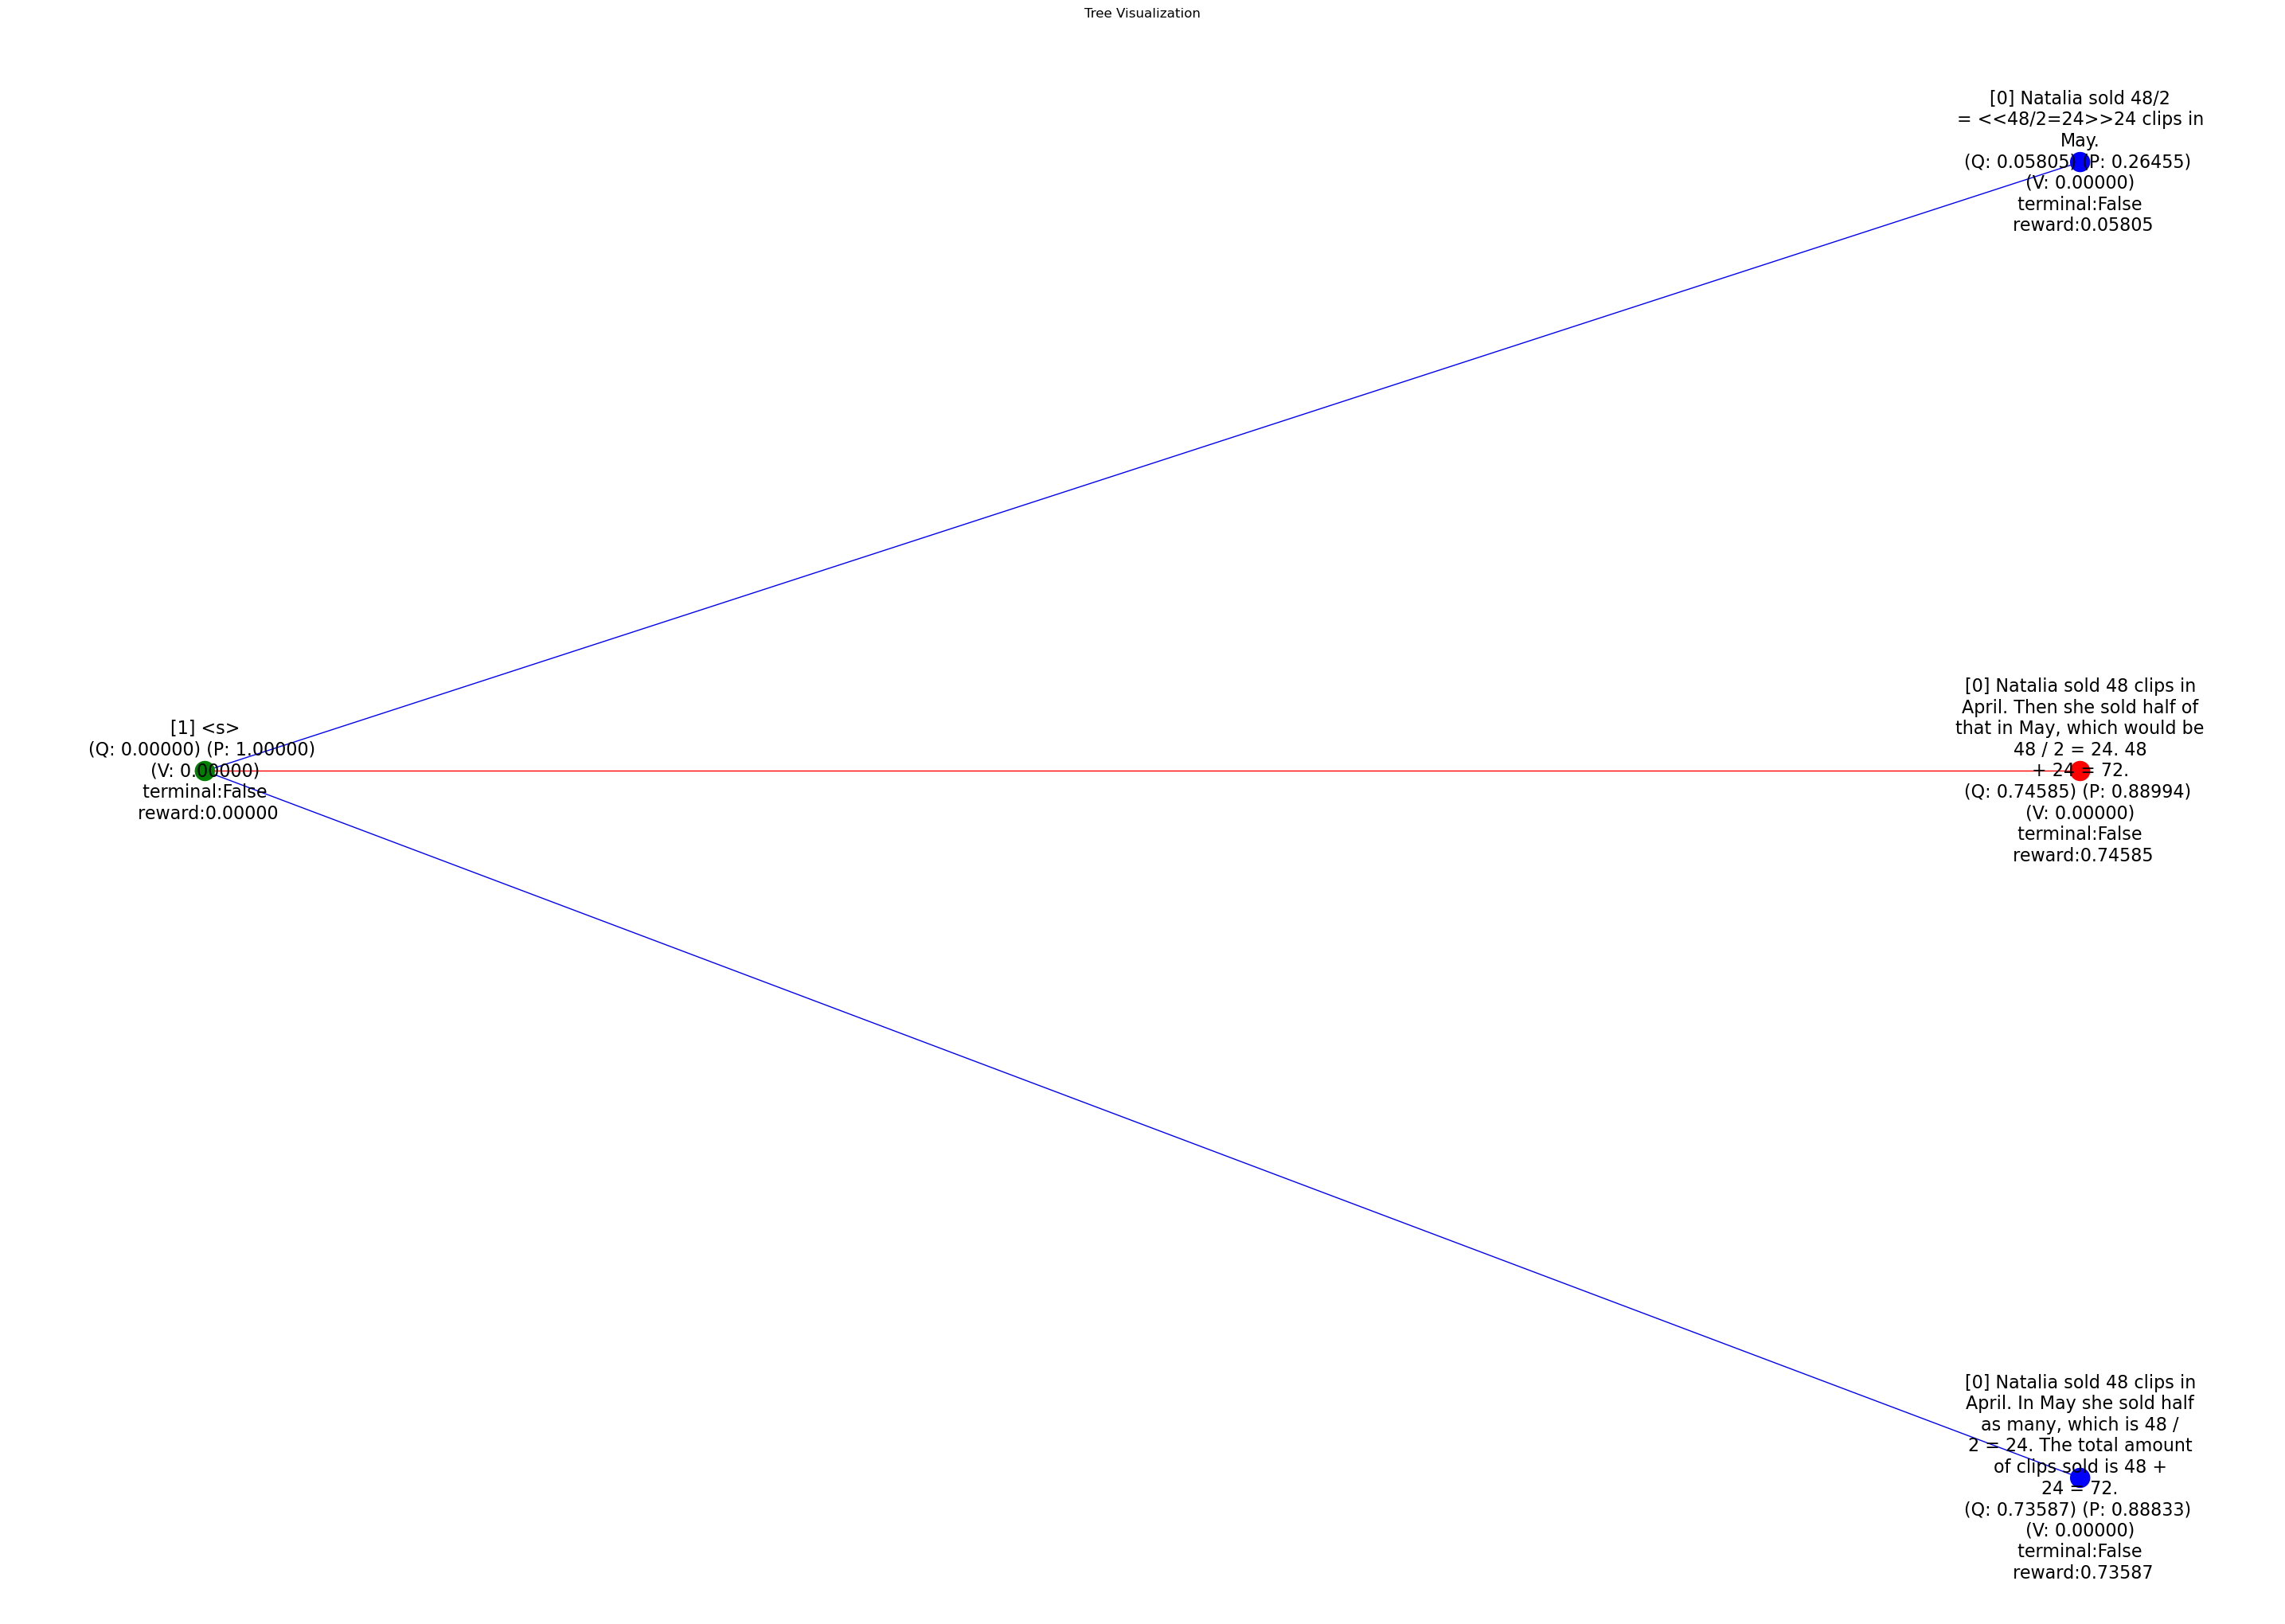

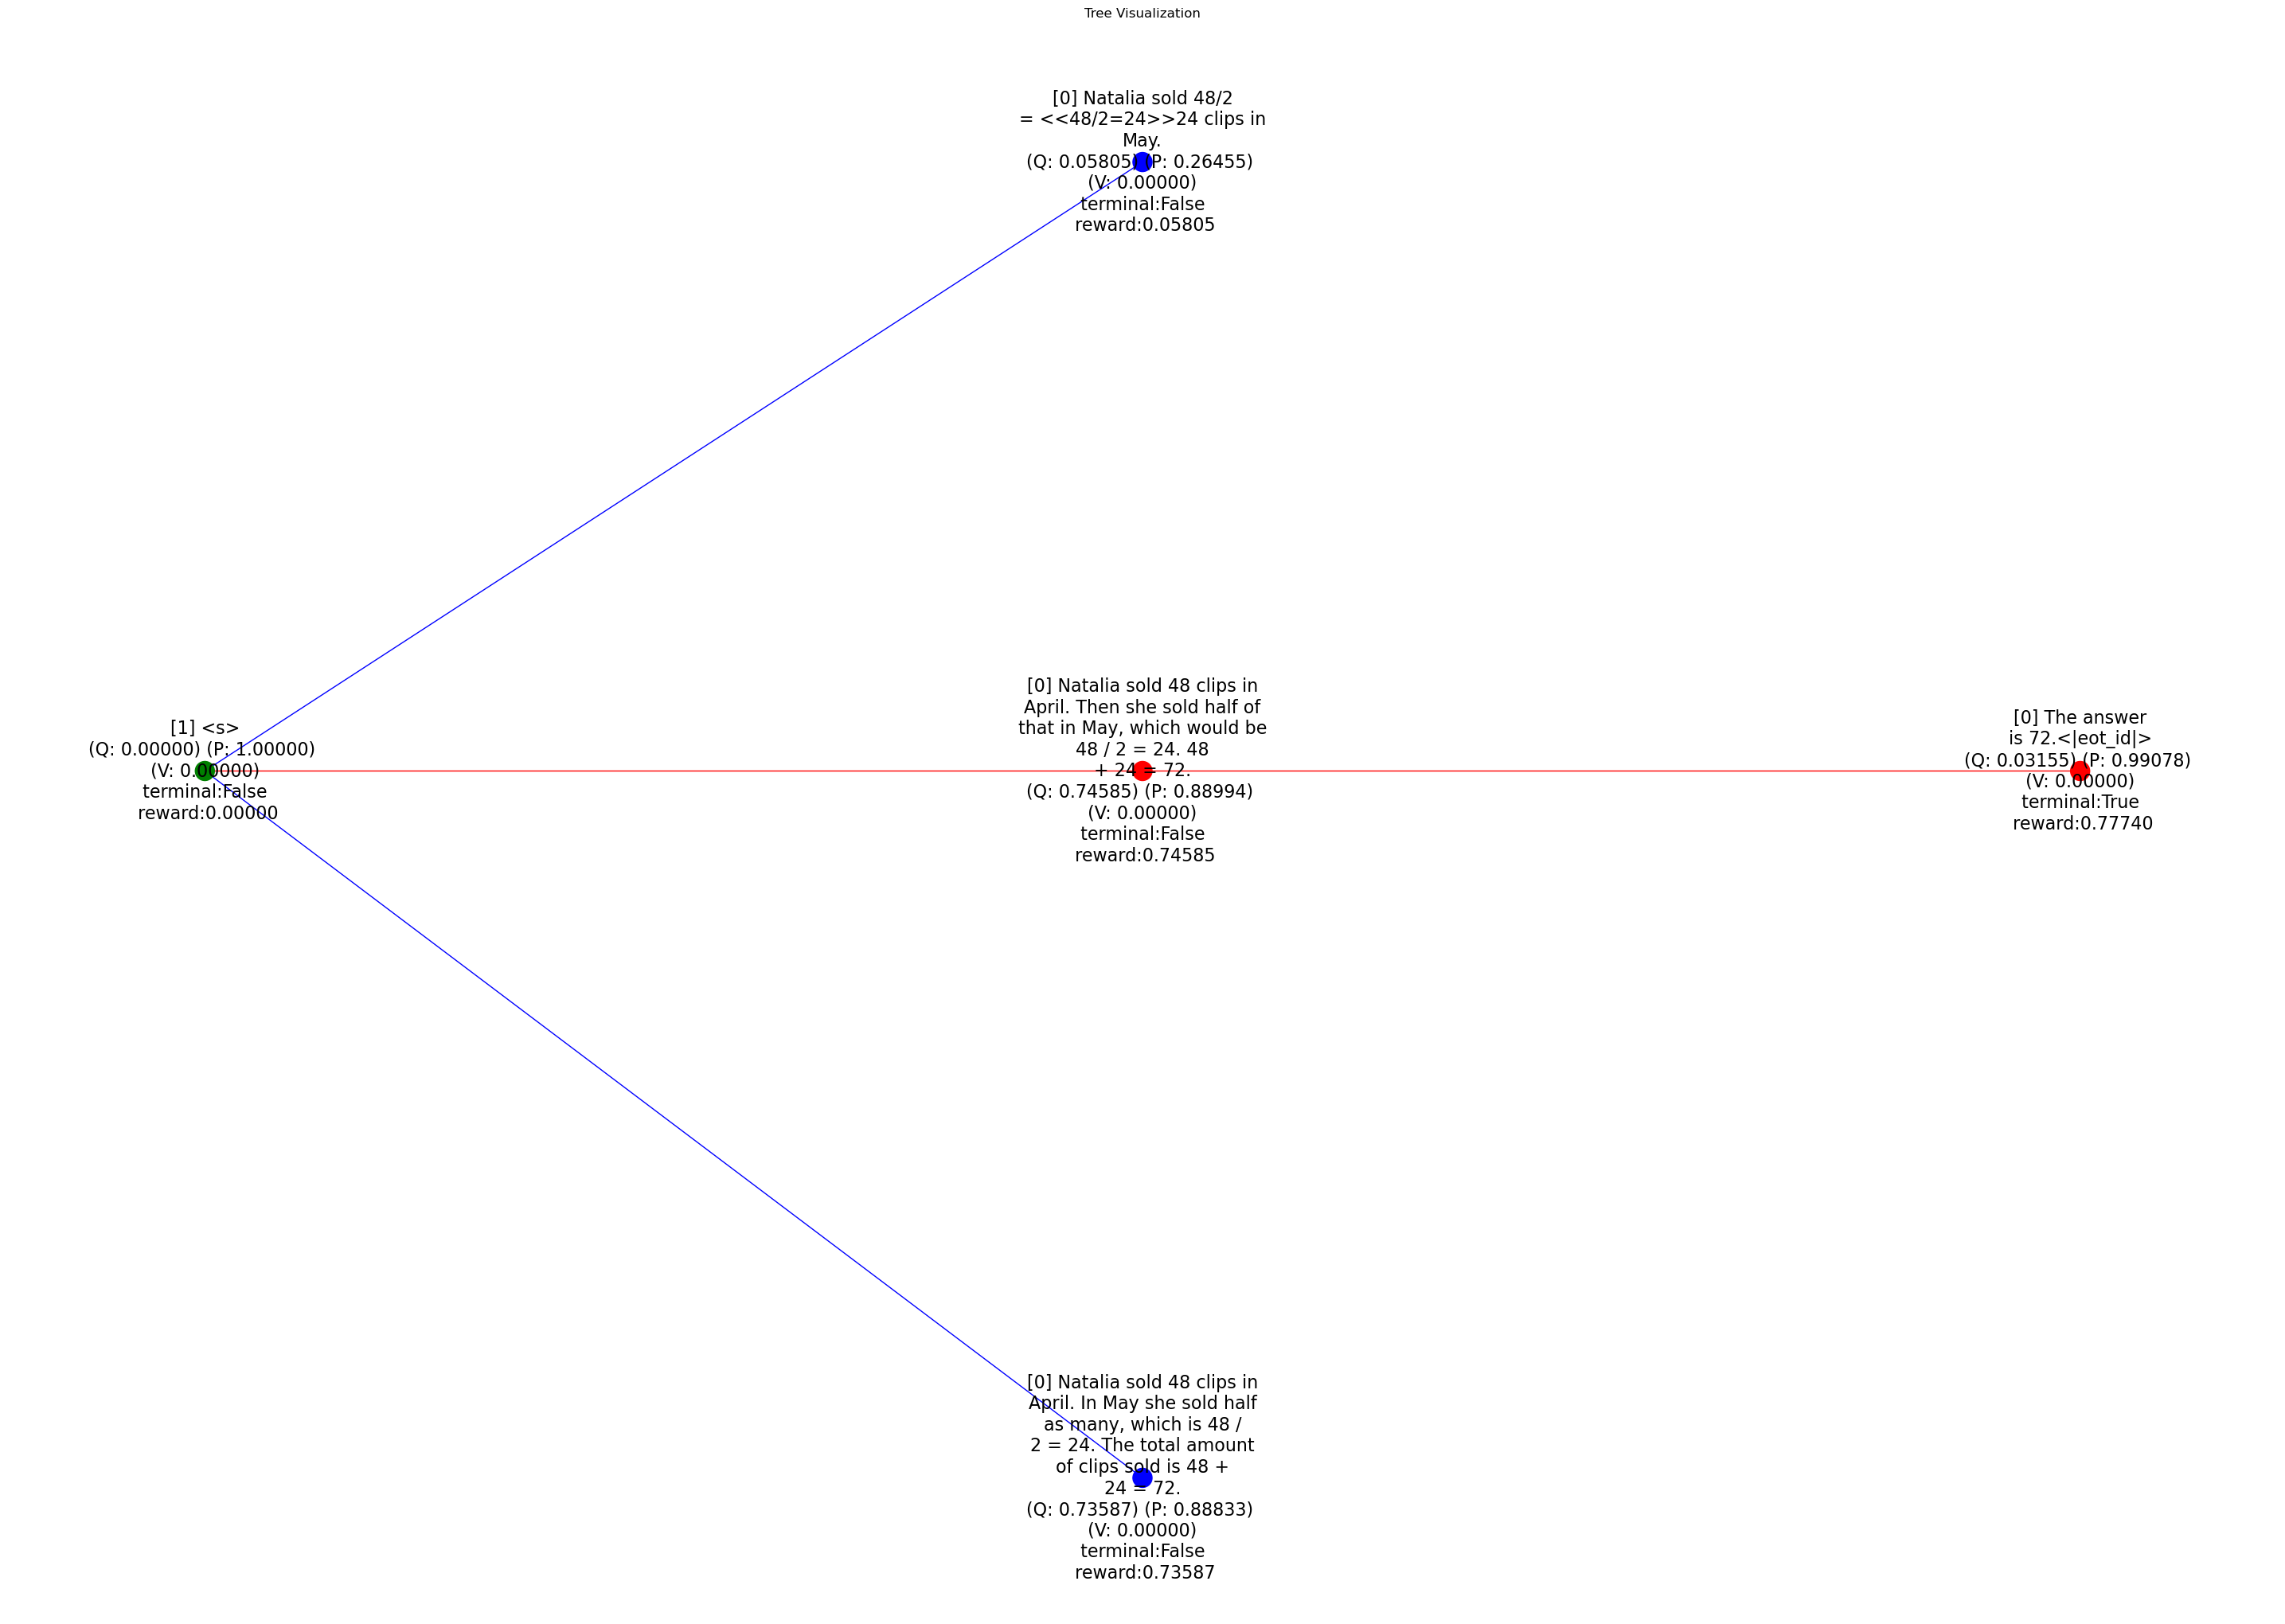

TREE AFTER BACKPROPAGATION:


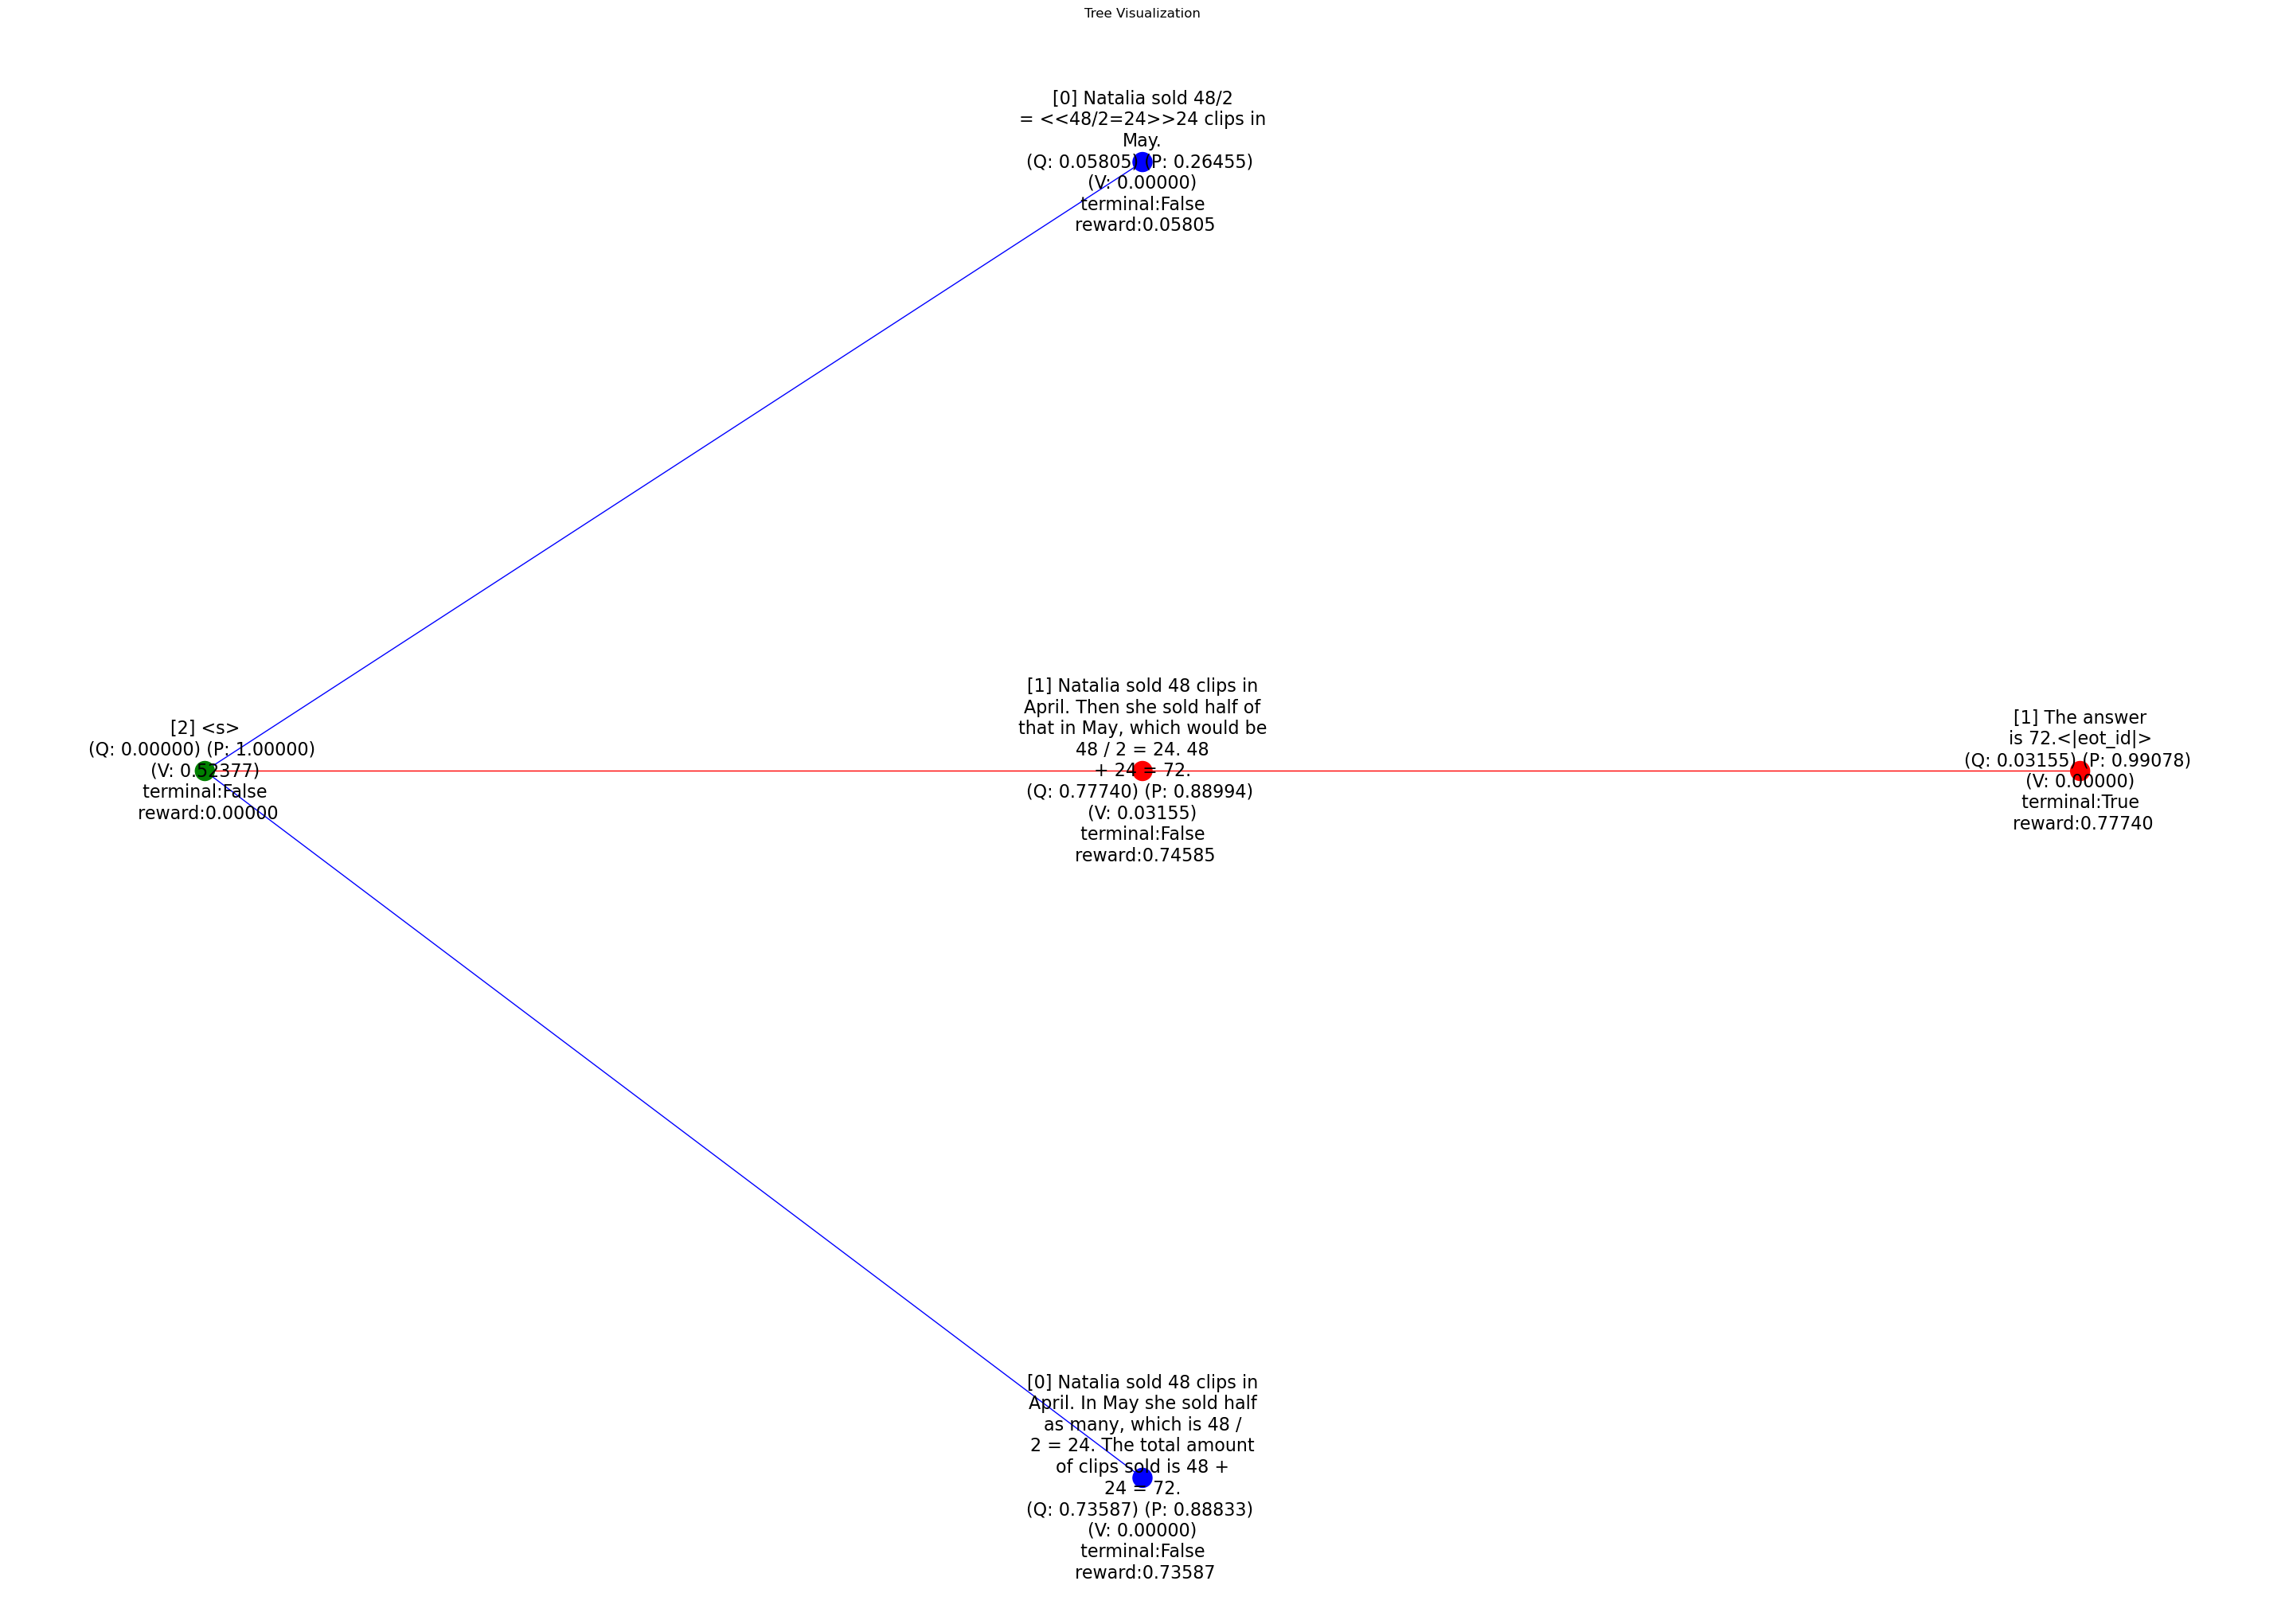

In [6]:
node_cnt = 0
search_cnt = 0
visualize_iteration_trees(batch_dir, node_cnt, search_cnt)

## Iteration 1

After the first iteration the reward from the first chosen path is backpropagated and a new path is built from the root, selecting again the child nodes with the best PUCT values.

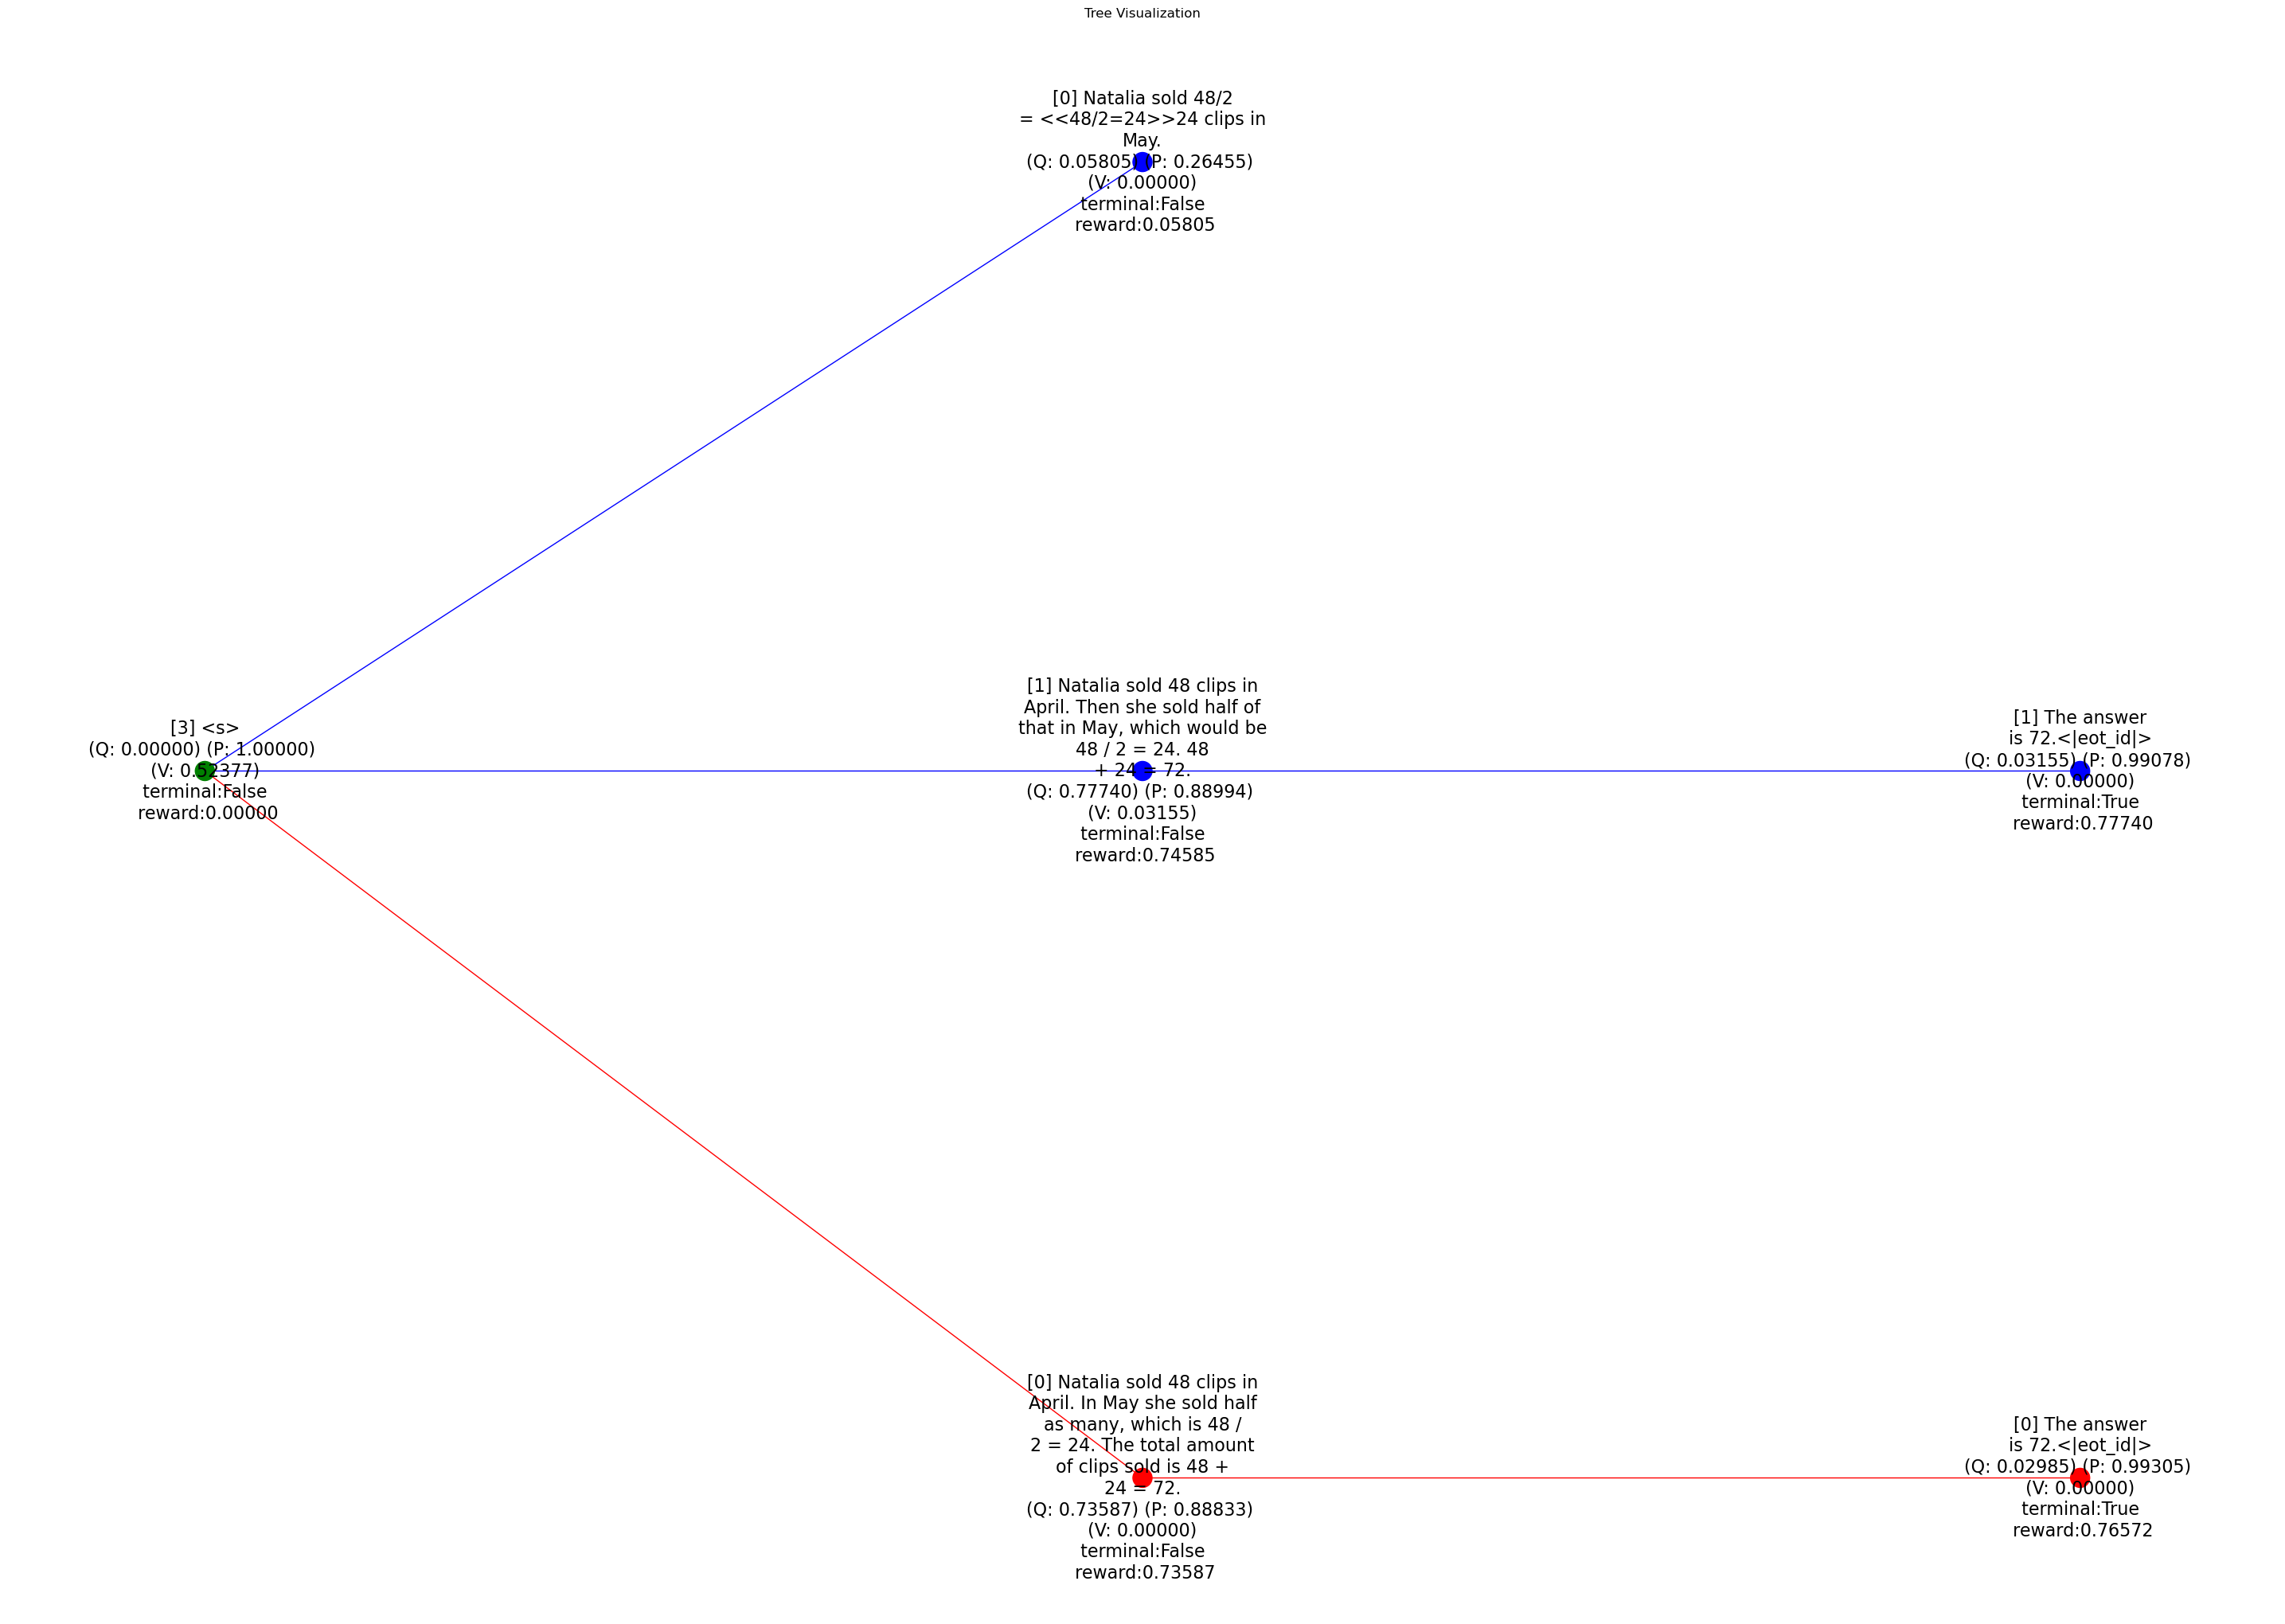

TREE AFTER BACKPROPAGATION:


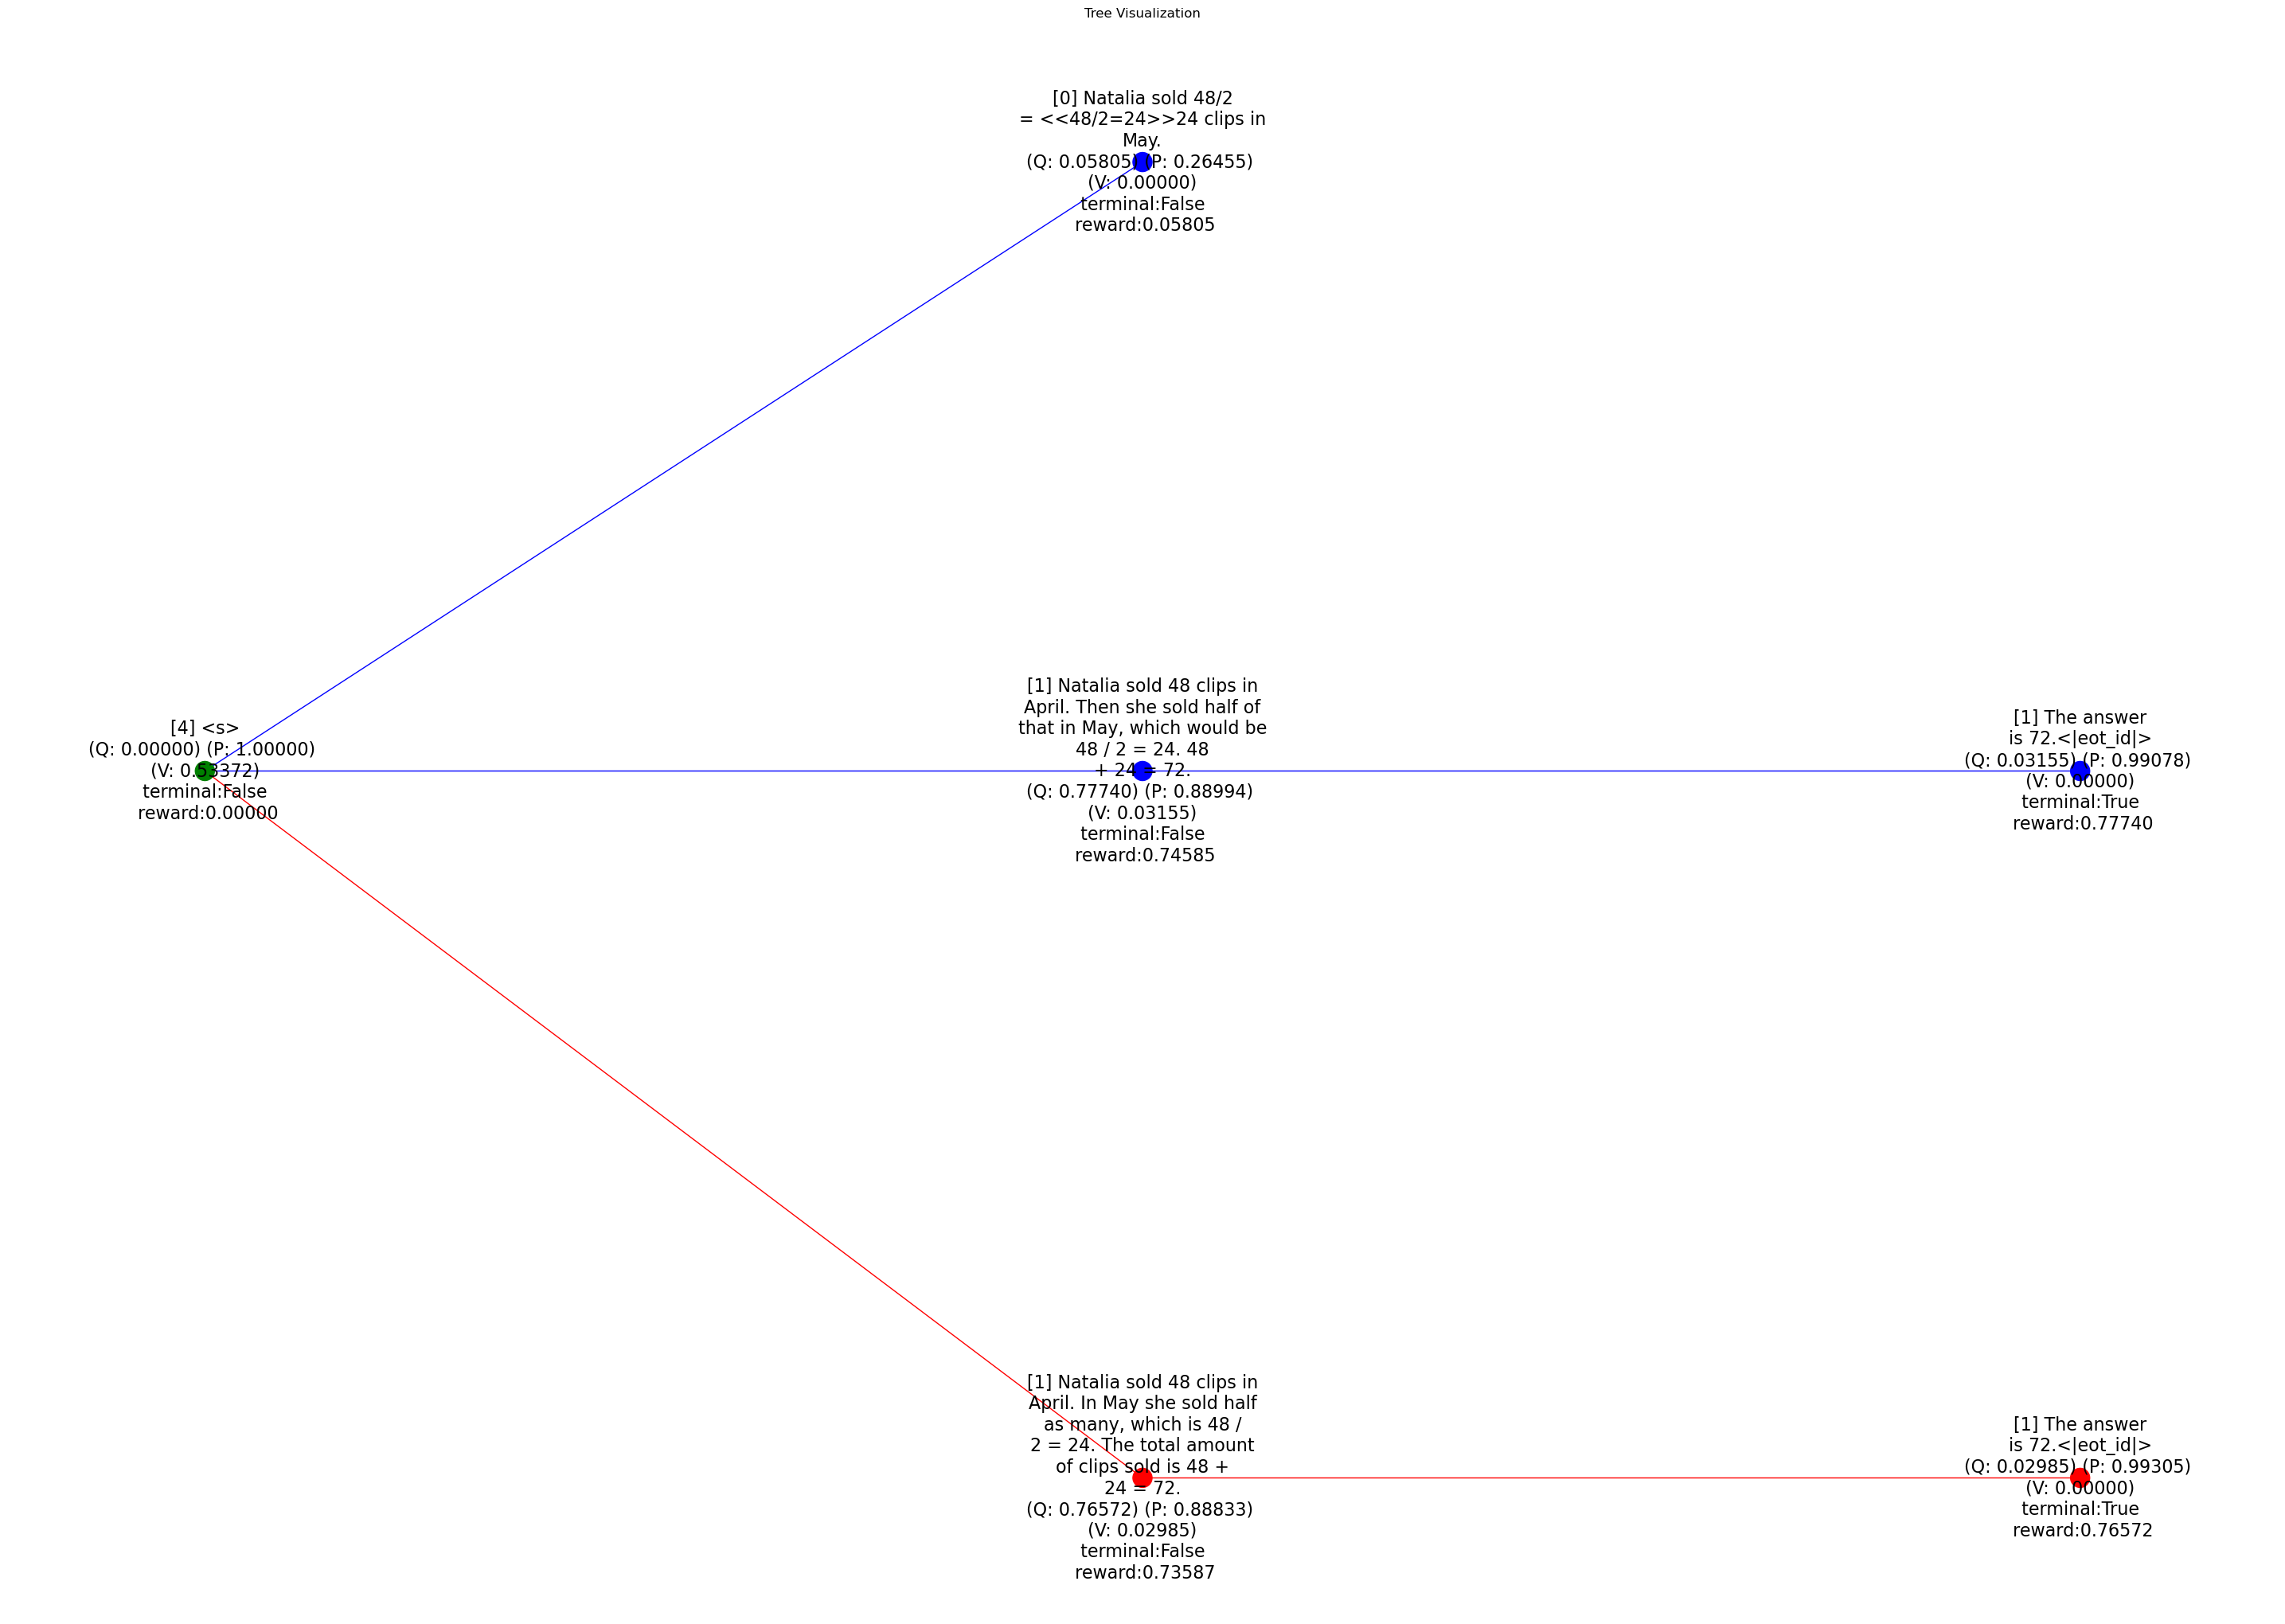

In [7]:
node_cnt = 0
search_cnt = 1
visualize_iteration_trees(batch_dir, node_cnt, search_cnt)

## Iteration 2

TREE AFTER BACKPROPAGATION:


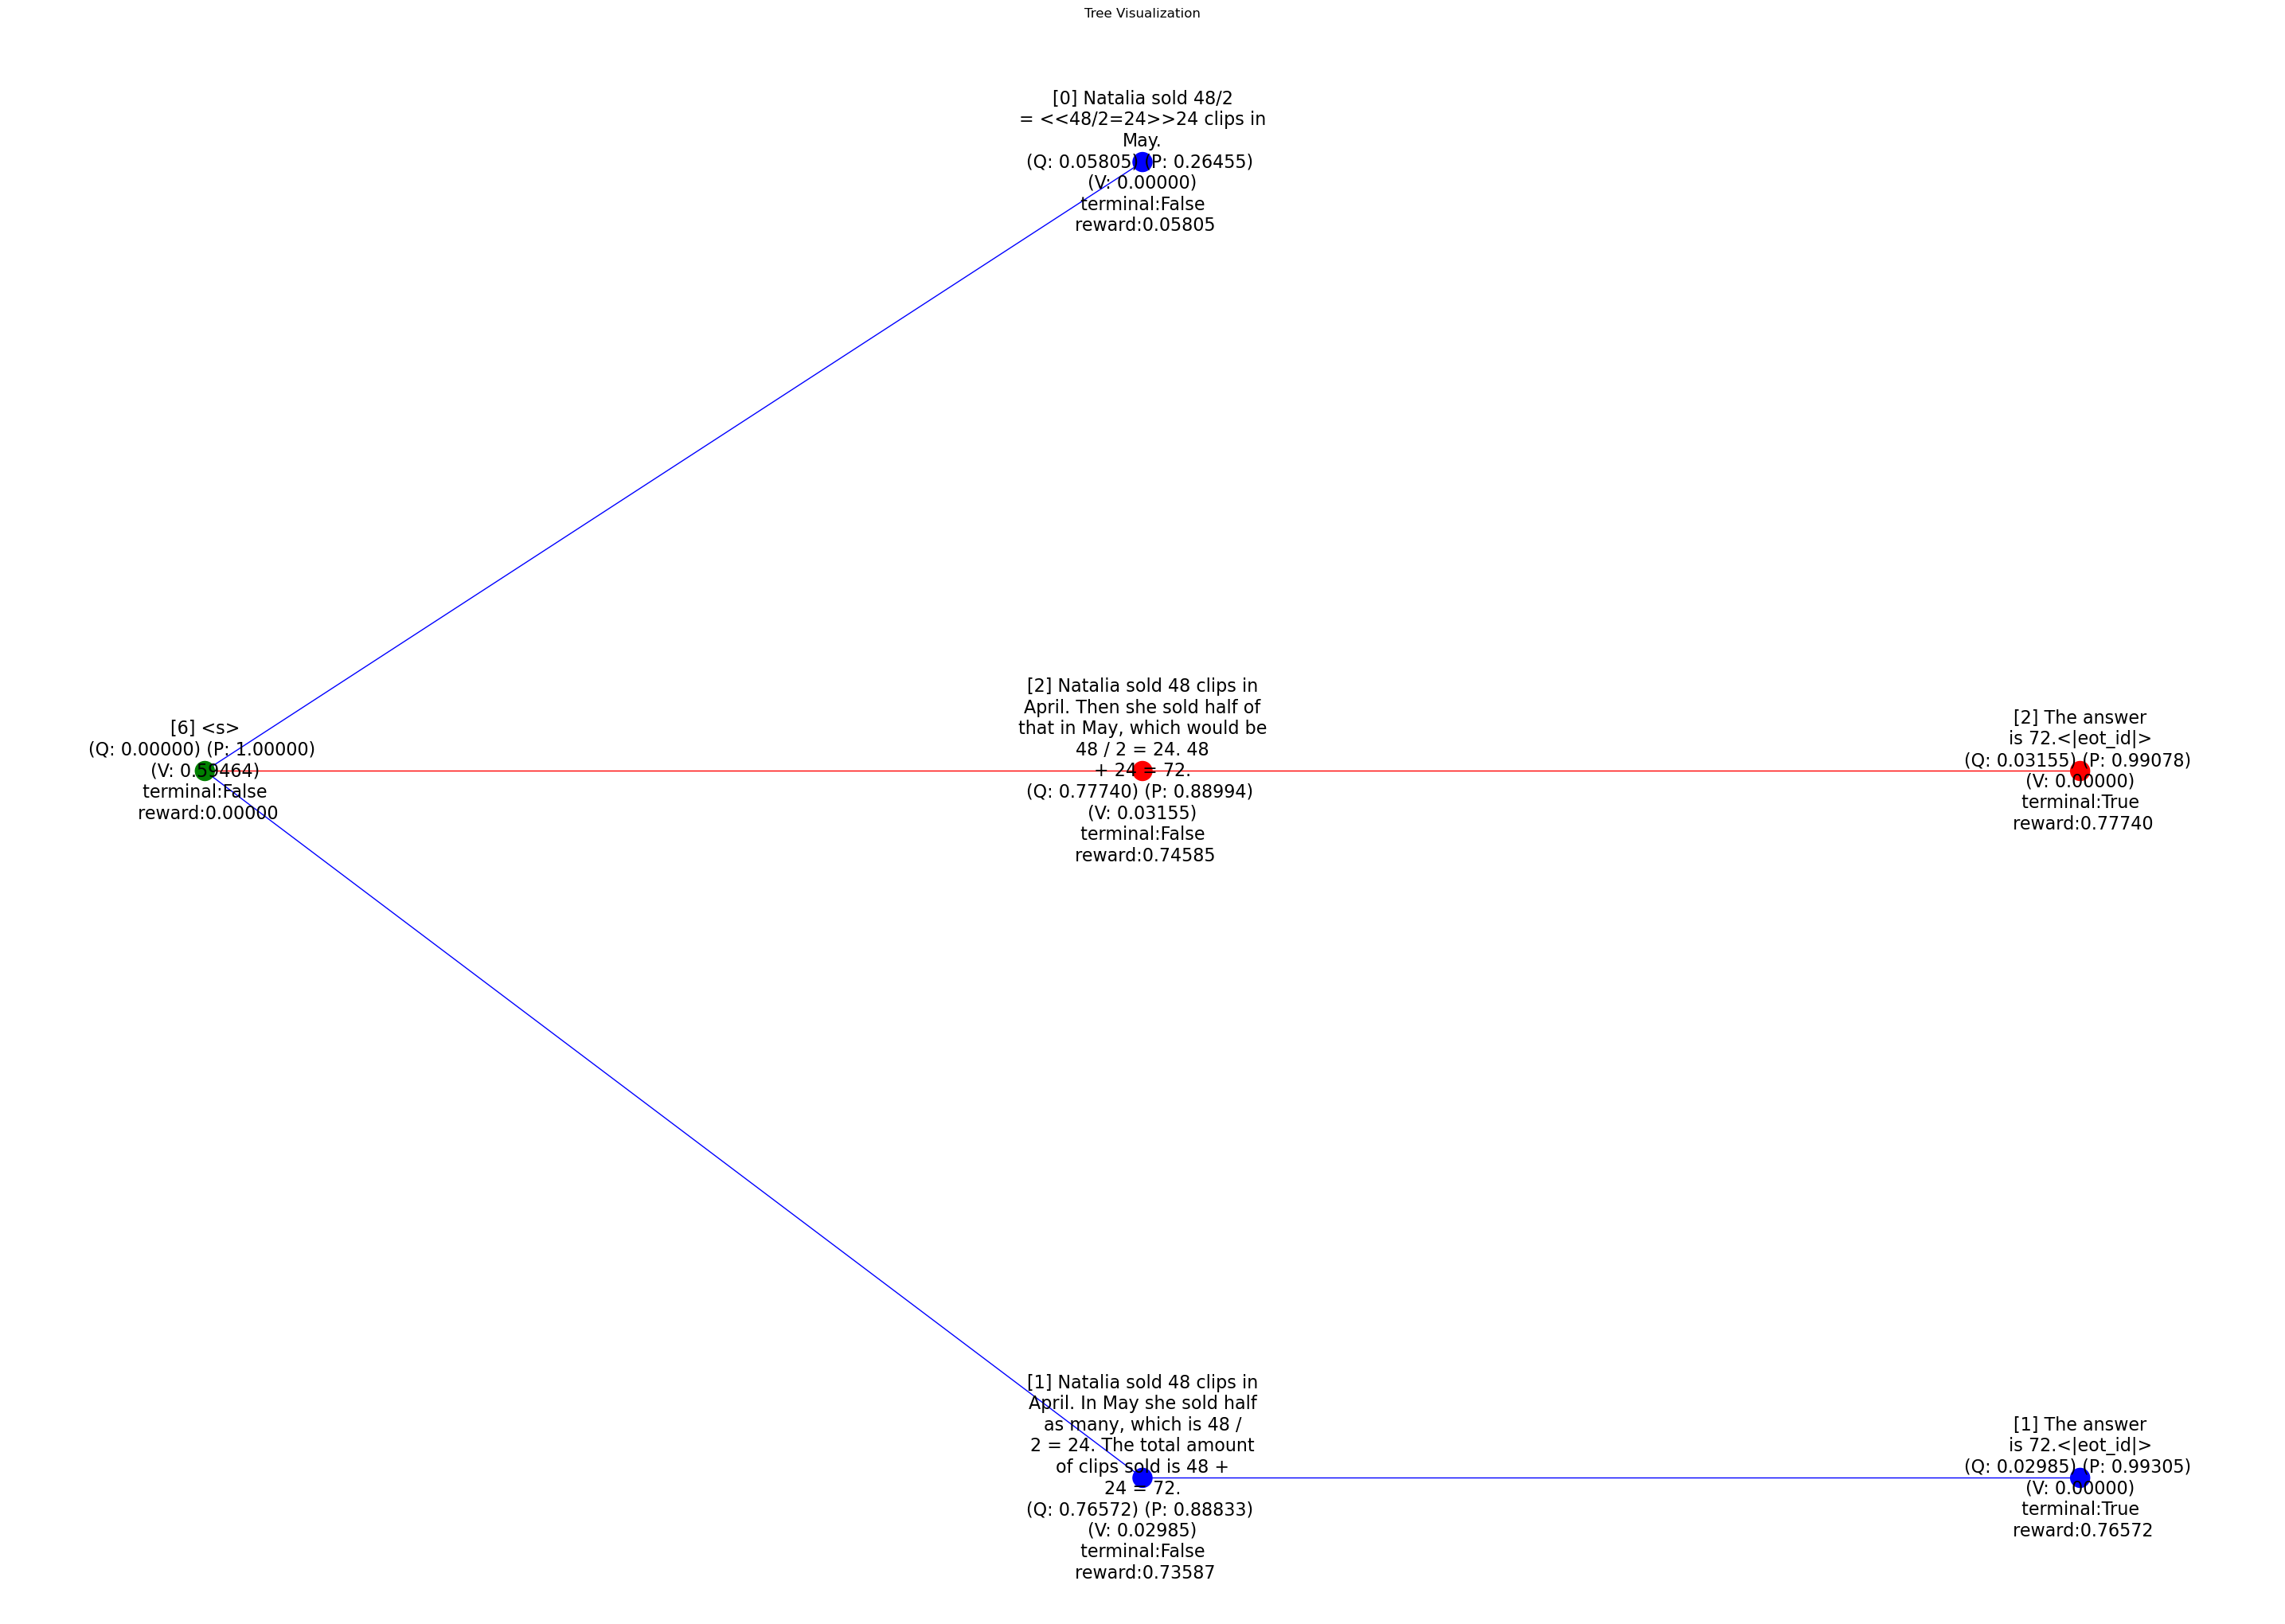

In [8]:
node_cnt = 0
search_cnt = 2
visualize_iteration_trees(batch_dir, node_cnt, search_cnt)

## Iteration 3

At iteration 3, all the leaf nodes are terminal nodes, so the tree stays the same and is not expaned anymore. Now only backpropagation takes place.

TREE AFTER BACKPROPAGATION:


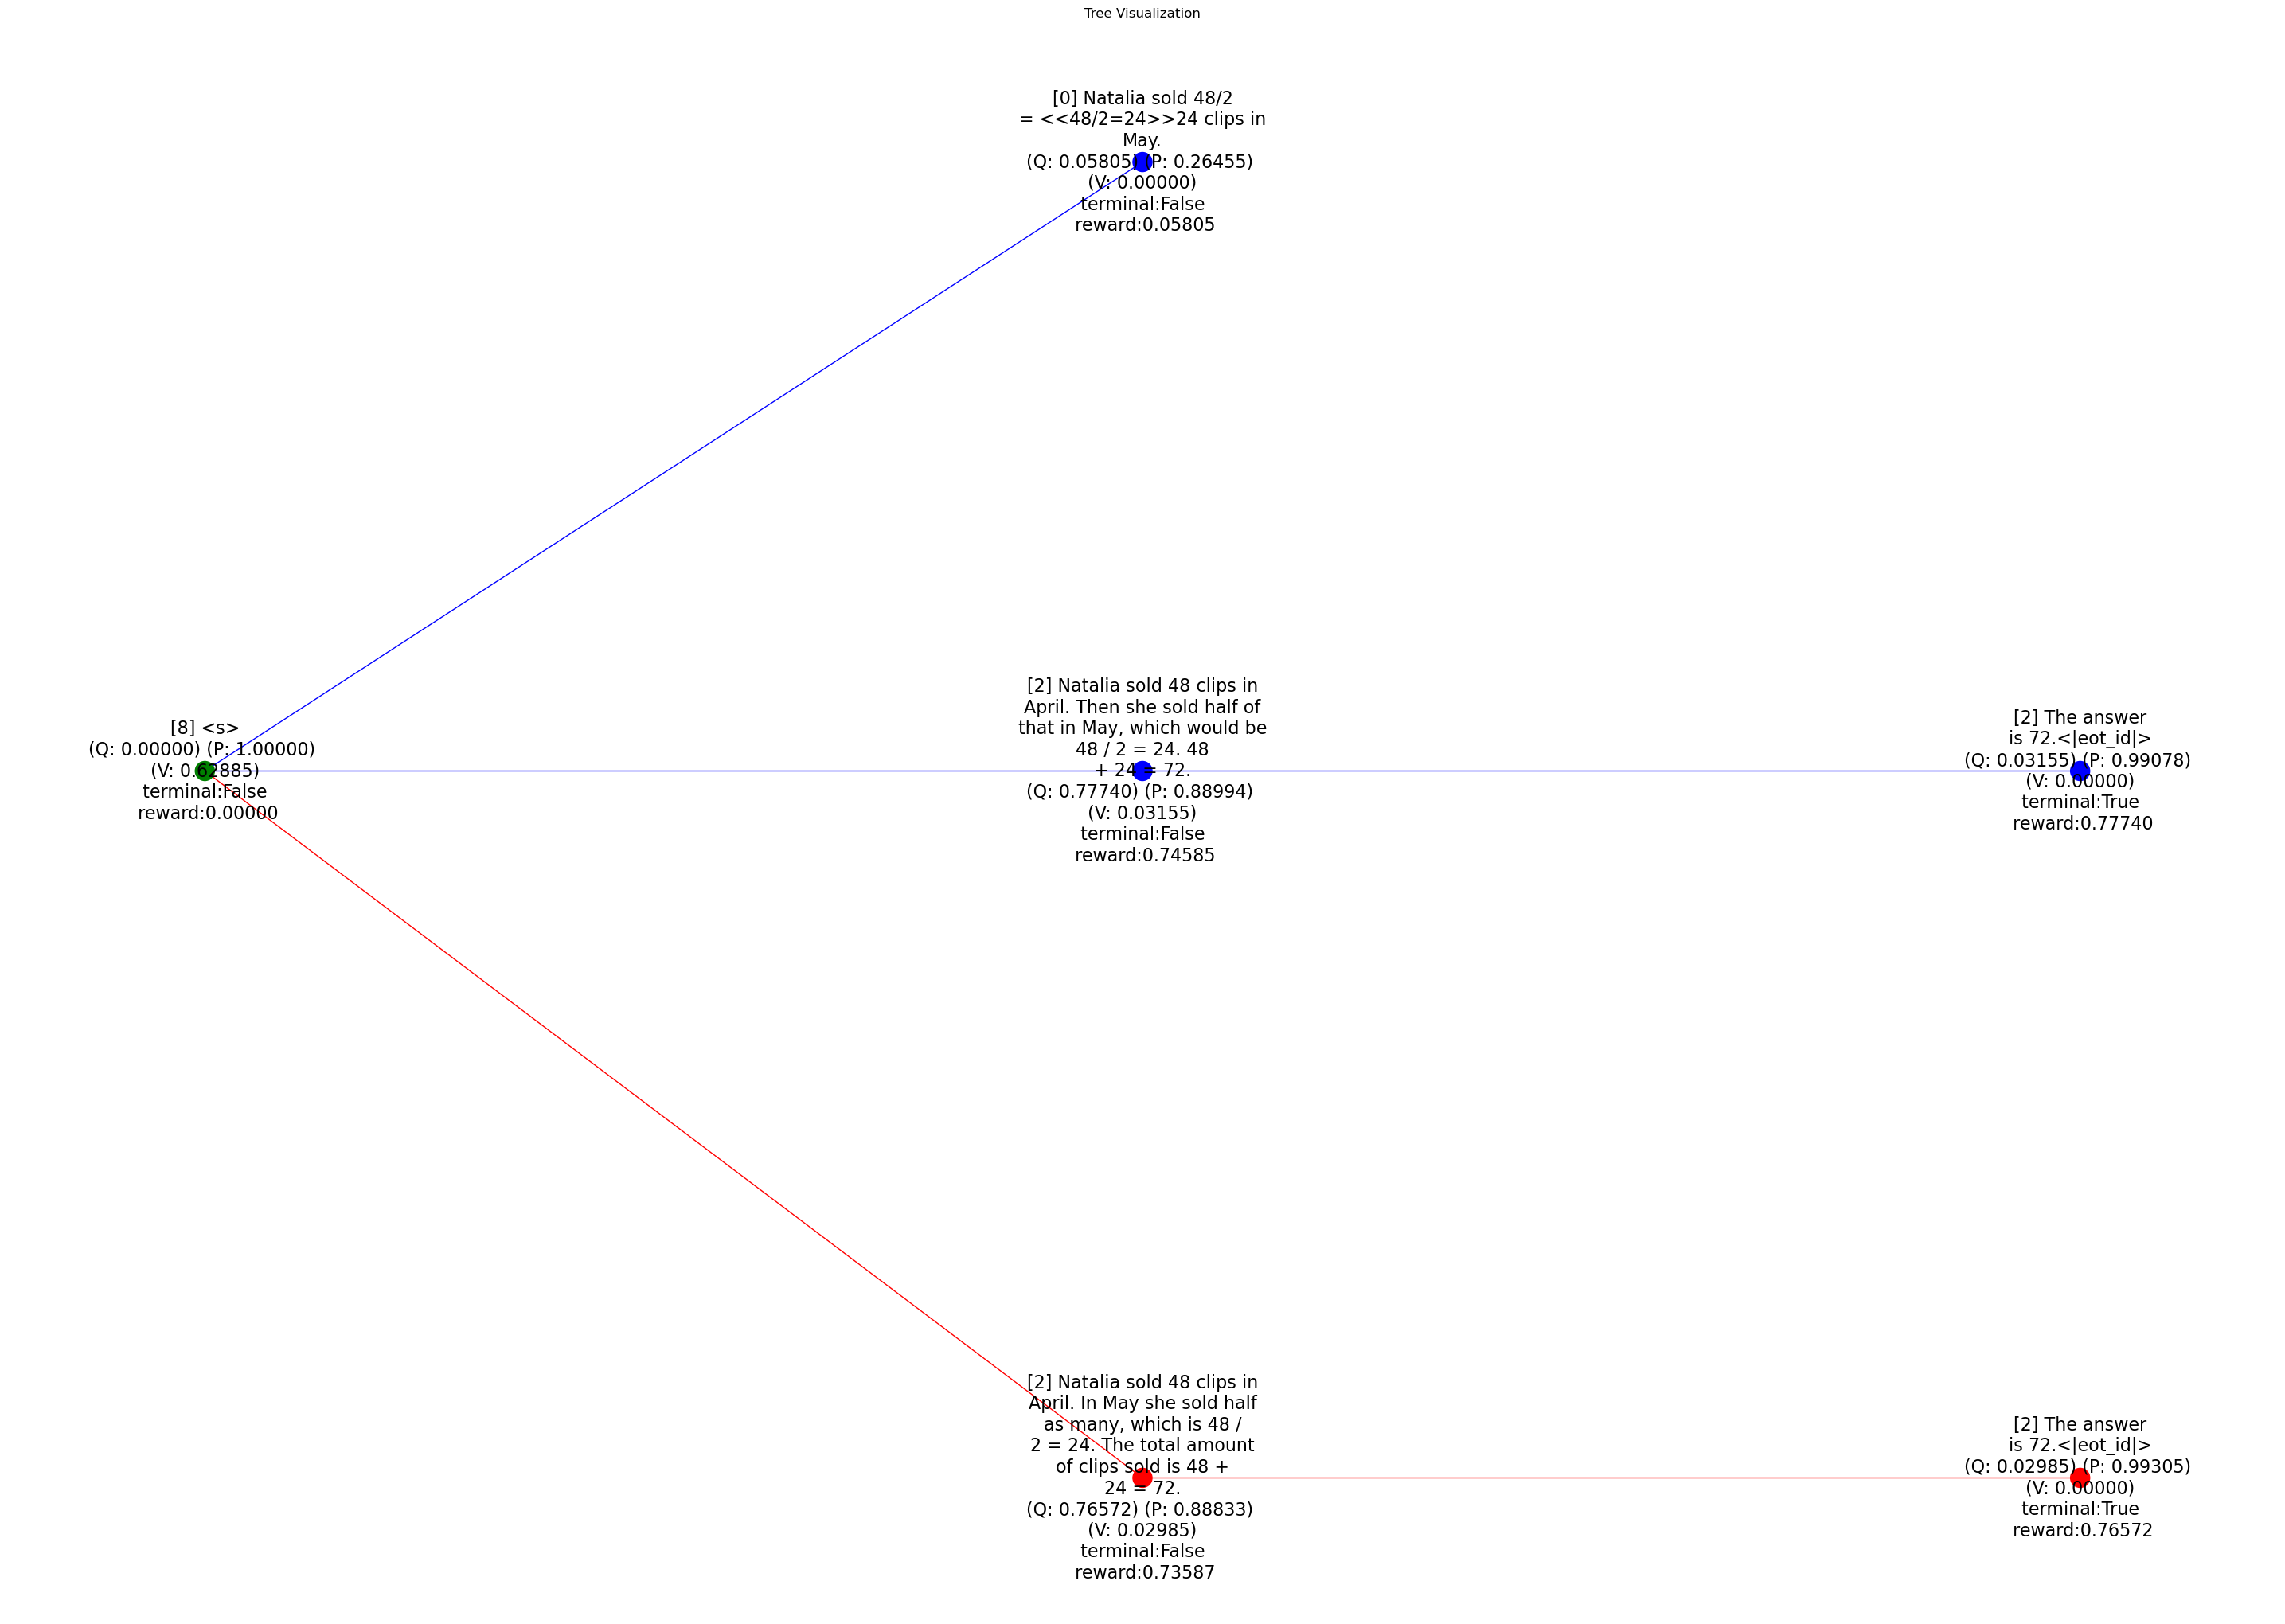

In [9]:
node_cnt = 0
search_cnt = 3
visualize_iteration_trees(batch_dir, node_cnt, search_cnt)

# Node 1

## Iteration 0

TREE AFTER BACKPROPAGATION:


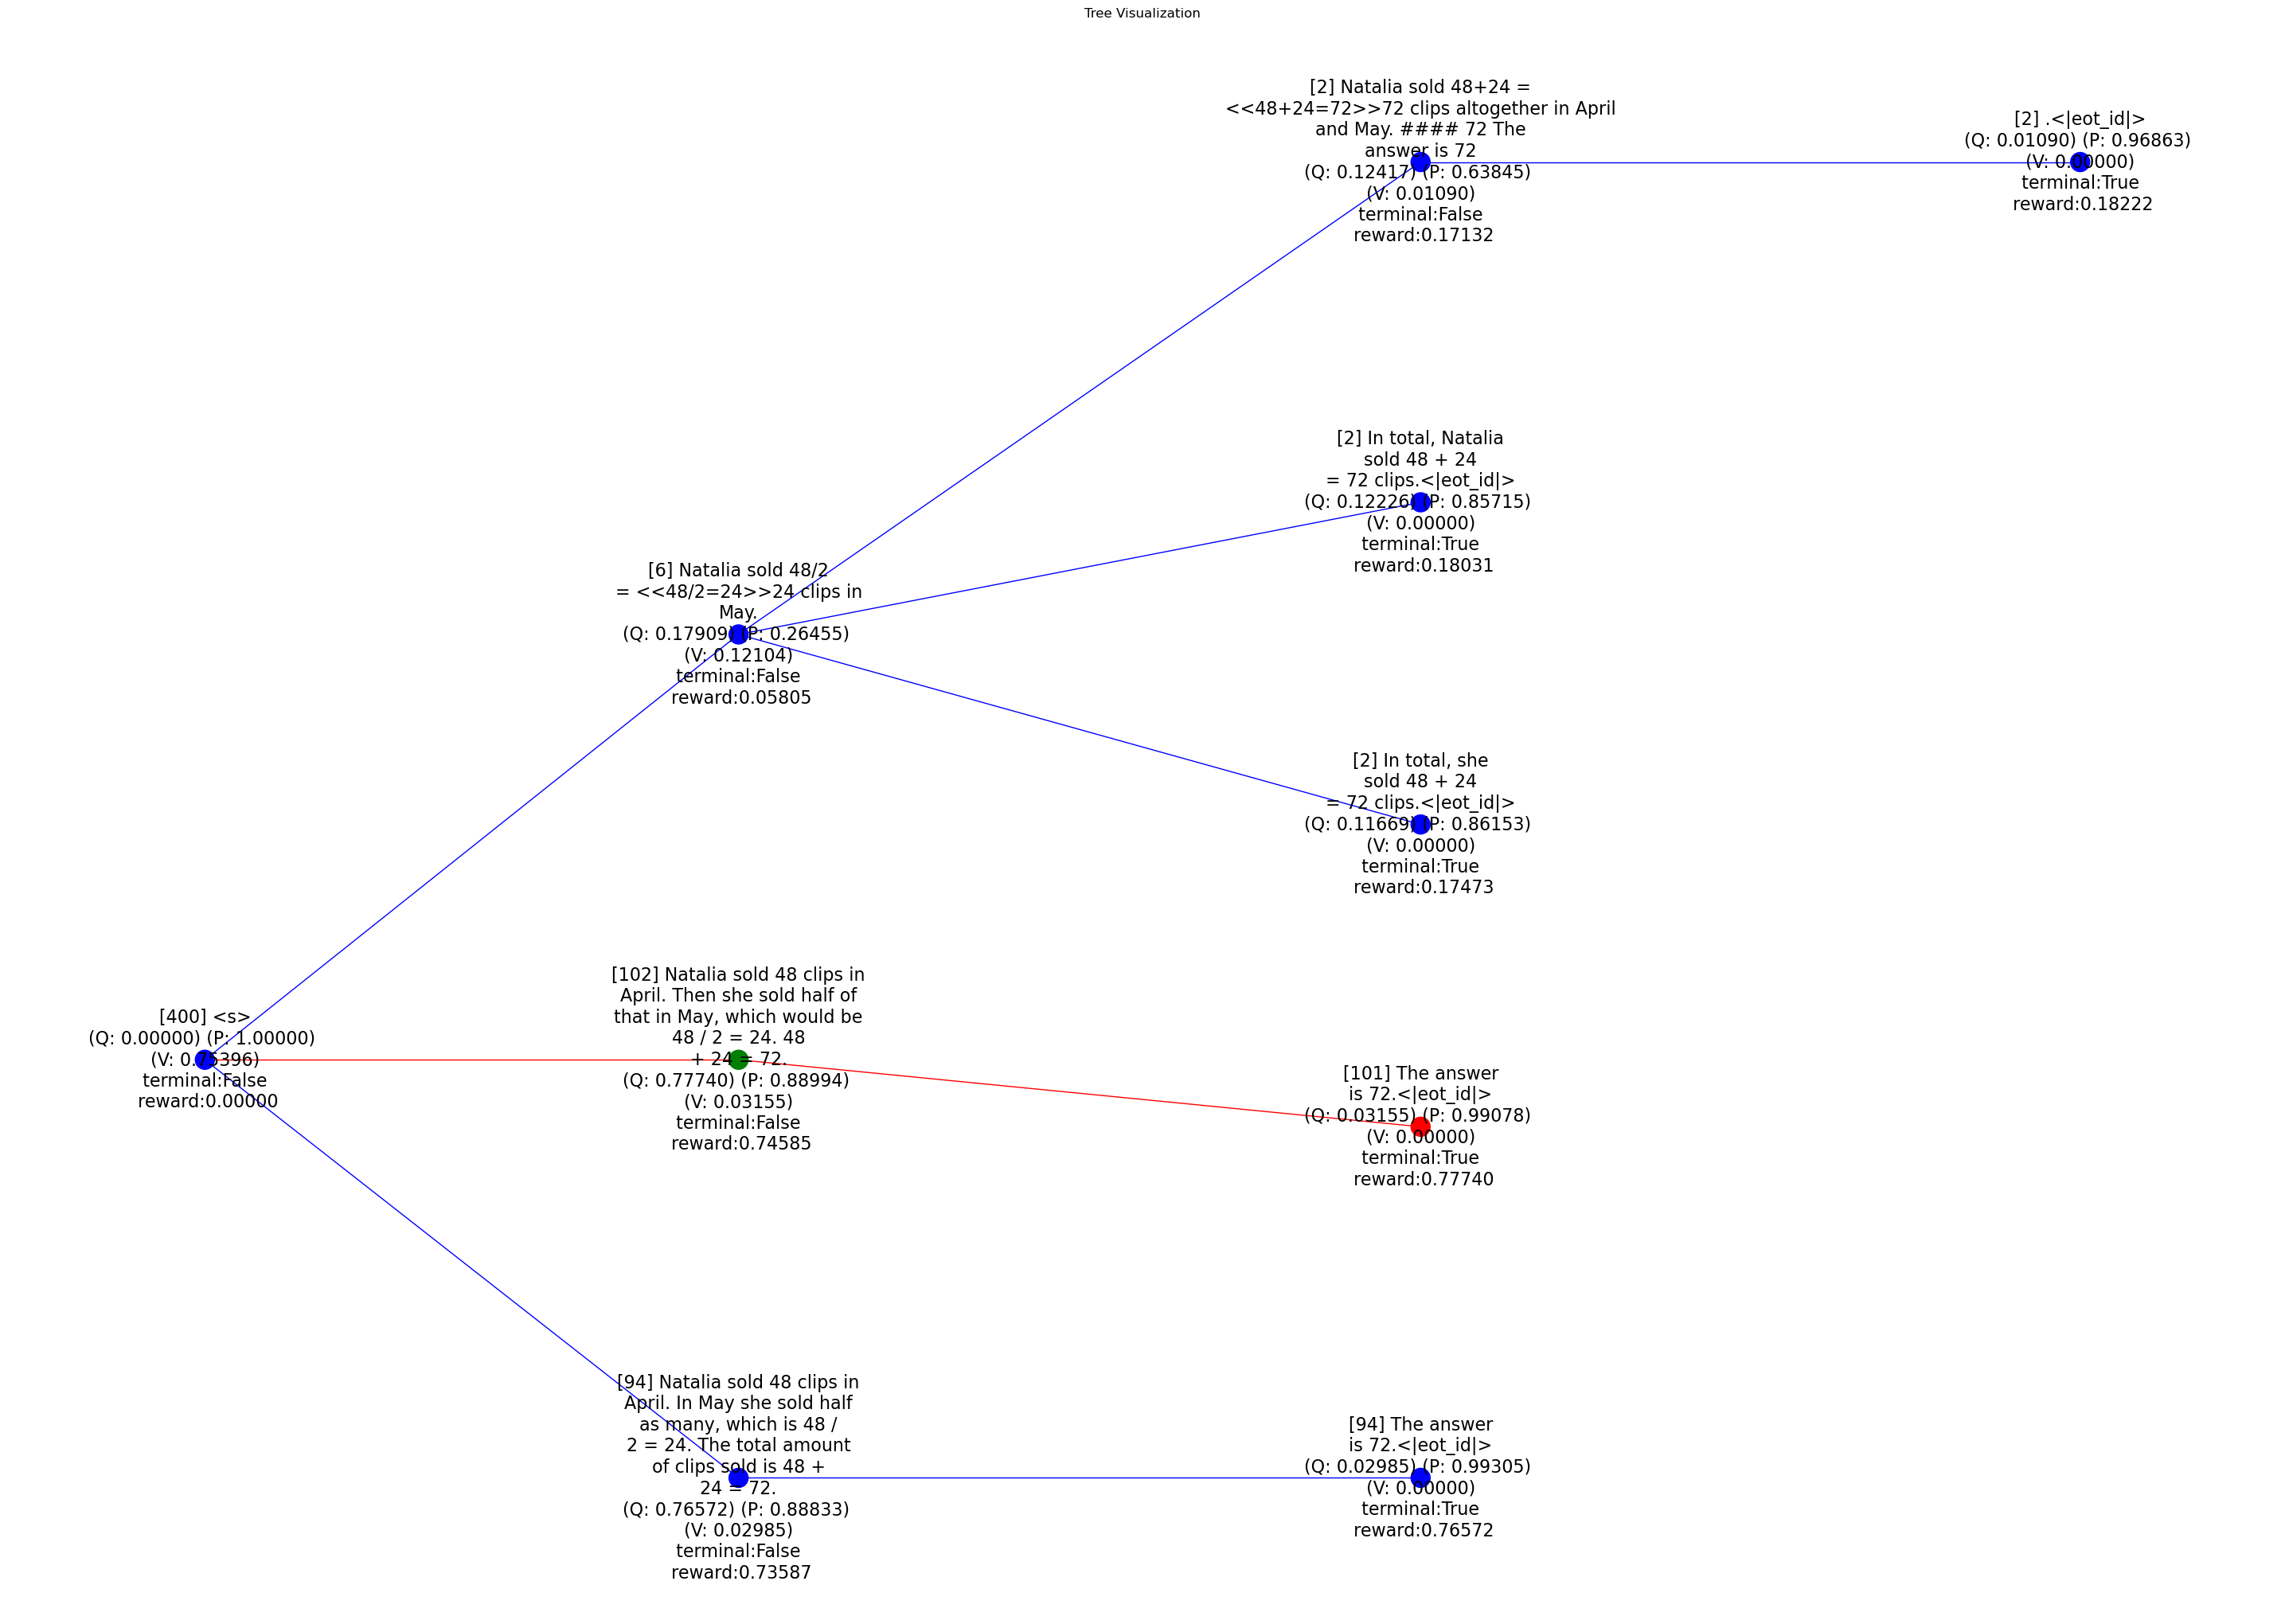

In [10]:
node_cnt = 1
search_cnt = 0
visualize_iteration_trees(batch_dir, node_cnt, search_cnt)

## Predicted Path

Select based on visit counts

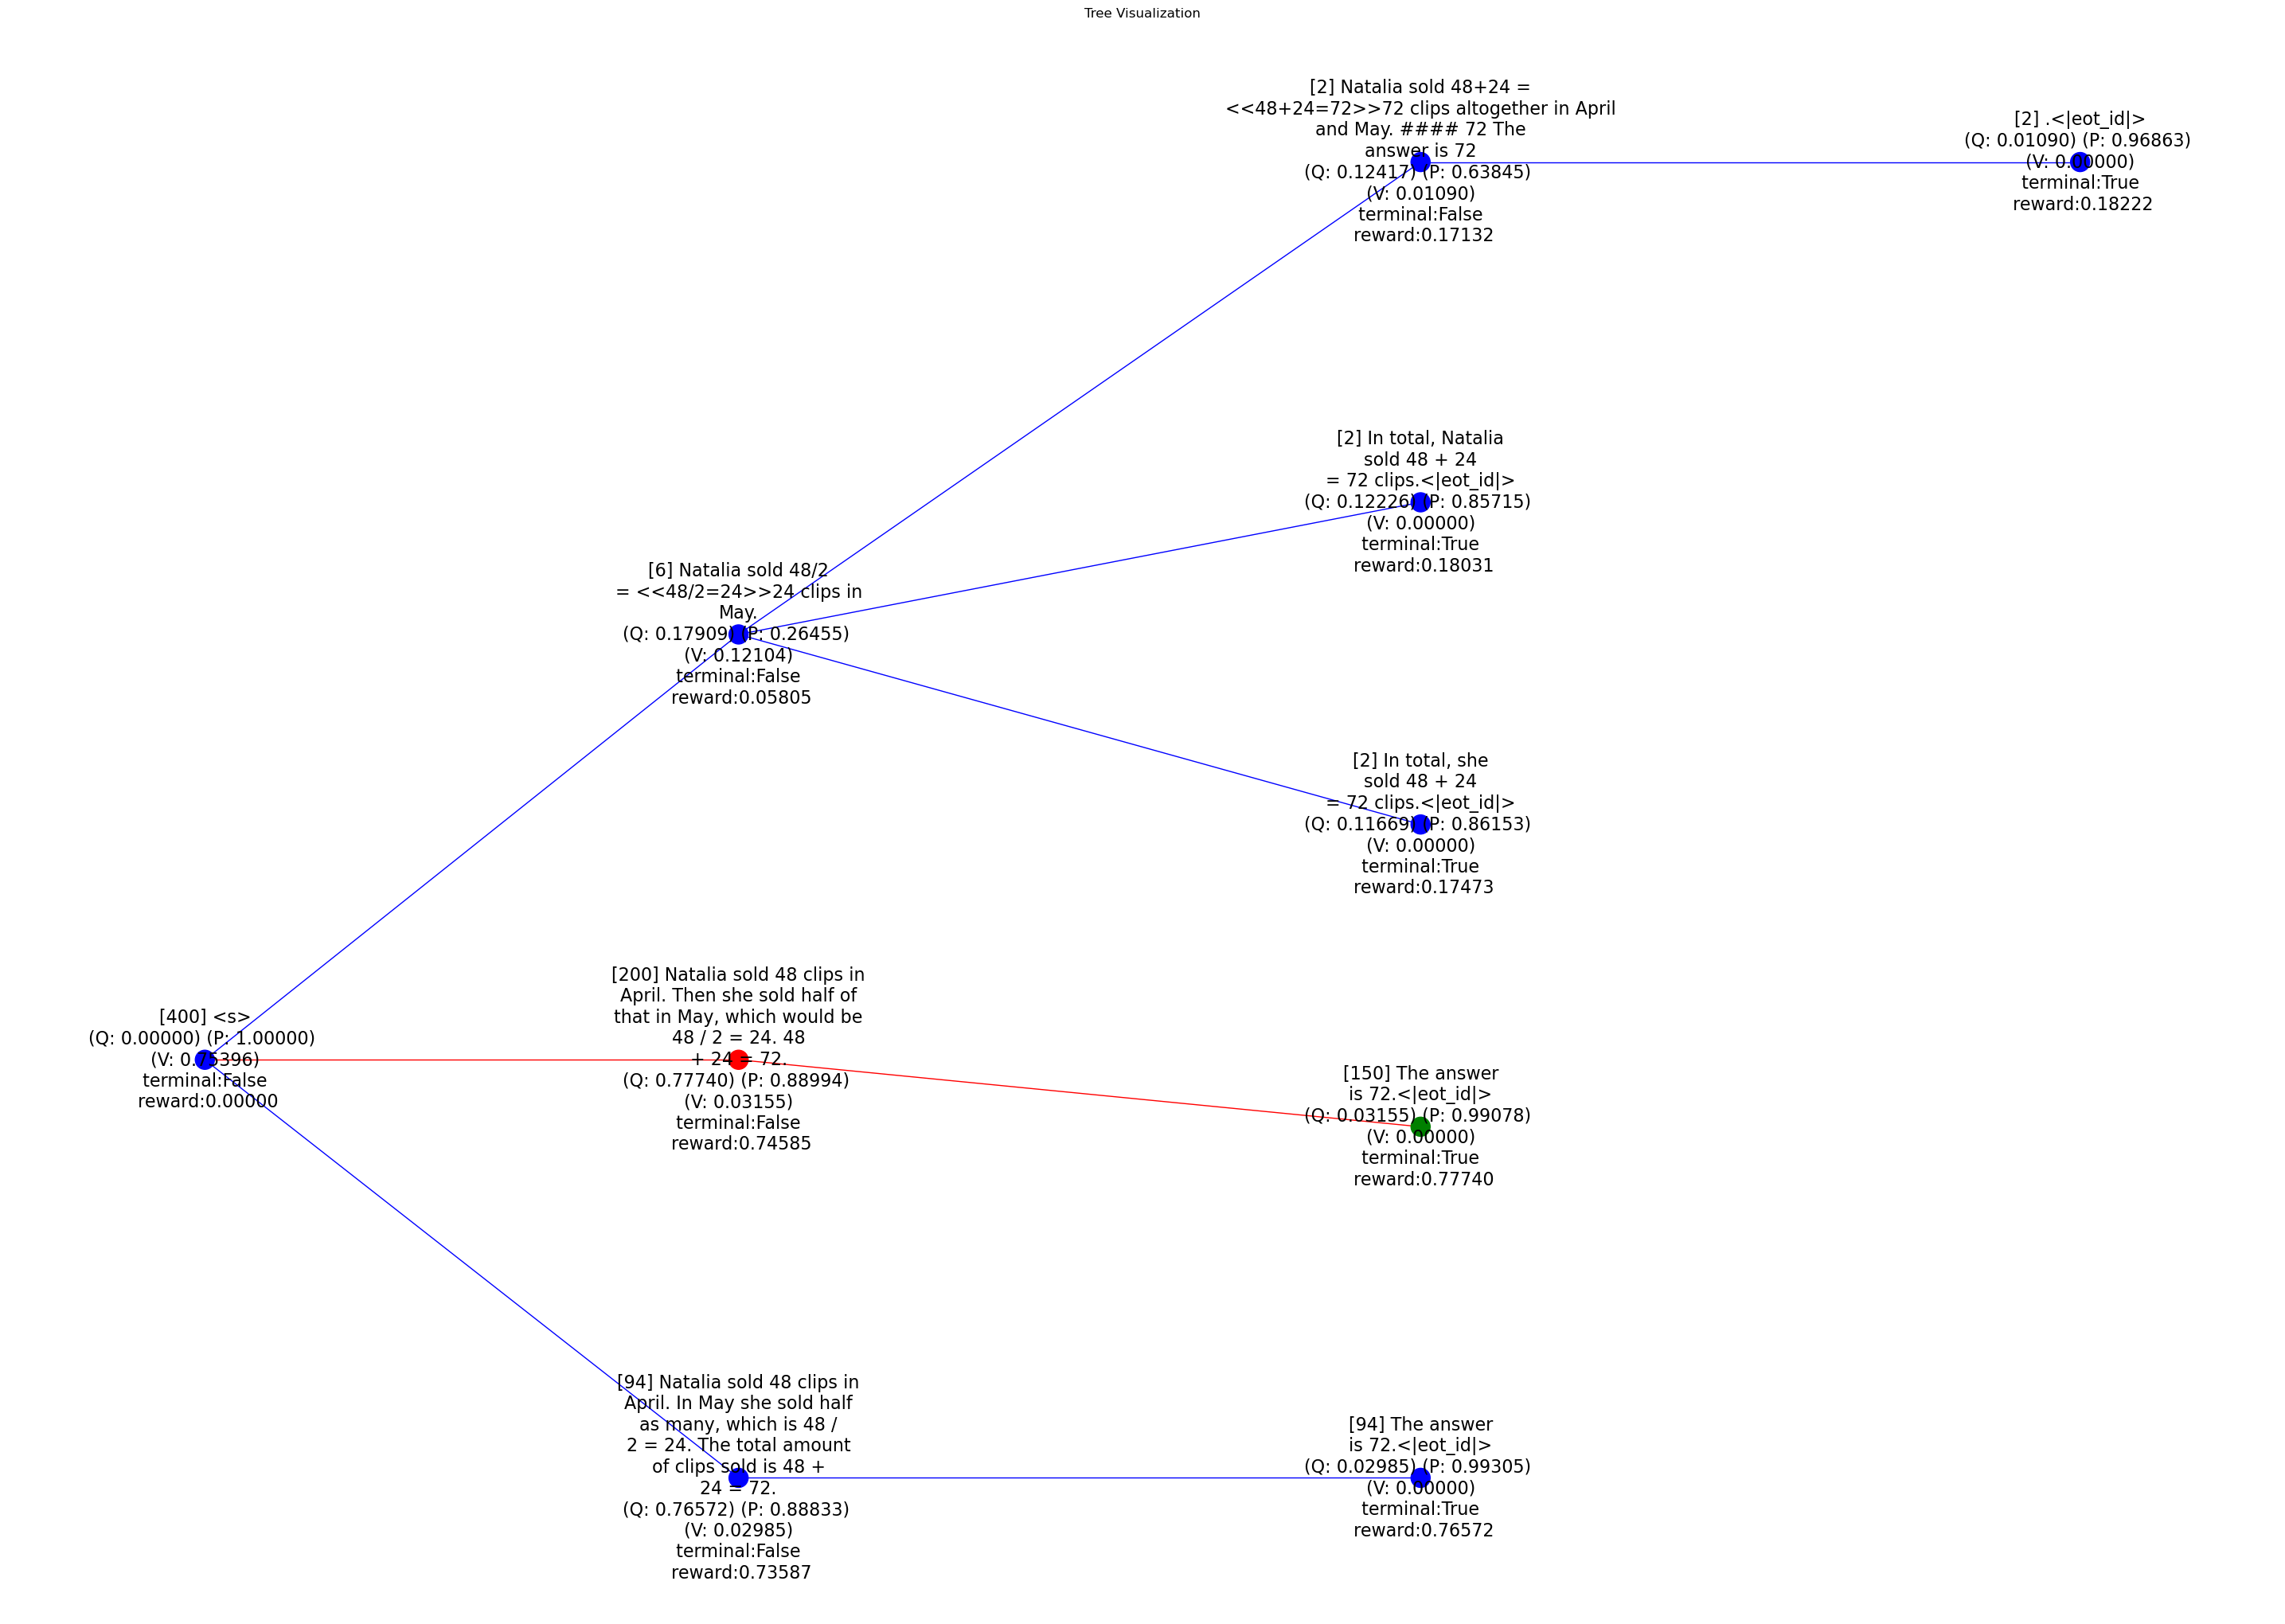

In [11]:
visualize_predicted_path(batch_dir)

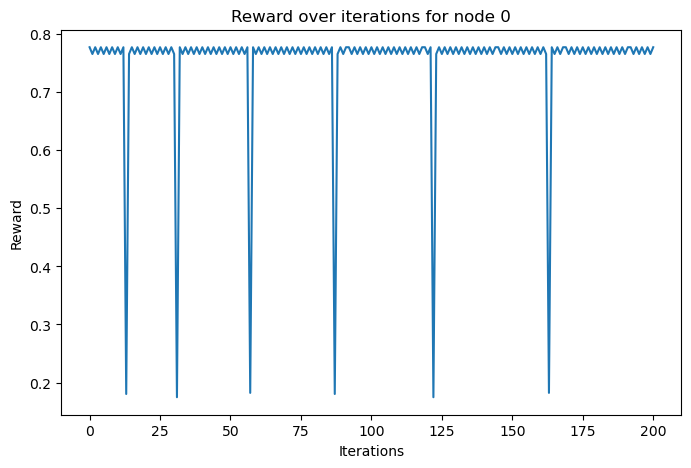

In [12]:
node_cnt = 0
visualize_reward_over_iterations(batch_dir, node_cnt)